Nombre: Daniel Díaz Barriga Gómez del Campo
 
Clave:  197242

# Recomendacion de Modelo de Default Para Banco

El objetivo de este proyecto es entrenar un modelo y recomendar al banco como utilizarlo.  
Puedes agregar mas snippets, usar fuentes de internet, otras librerias, comentar con otras personas, pero asegurate de ser muy explicitx con tu explicacion. Imagina que este documento lo va a evaluar una persona tecnica y una persona no tecnica, por lo que tienes que ser muy cuidadosx con lo que dices pues tiene que ser verdad y no tener errores metodologicos, pero tambien partes que sean faciles de leer.

1. Deberas replicar el analisis/codigo que utilizamos en el `AutoML` coun autogluon (o con cualquier otra libreria que desees), pero tendras que elimar la columna que especifica la `tasa de interes` o columnas equivalentes.  
   
2. Debes elegir (entrenar) dos modelo que no tenga `leakage`, que sean estadisticamente robustos y utiles para la operacion. Debes explicar de manera detallada con graficas, tablas y palabras por que propones el uso de cada modelo
   1. El primer modelo debe ser explicable (por regulacion debes ser capaz de explicar por que no se da el prestamo). Ofrece una guia para explicar como podria defenderse el banco con el modelo que promones
   2. El segundo debe ser elegido sin importar si es explicable o no  
   
3. Finalmente usando uno de los modelos anteriores (elige el que quieras) debes proponer al banco que tasa de interes utilizar para los prestamos (basandose en la probabilidad del modelo) bajo los siguientes escenarios
   1. El banco no es adverso al riesgo y quiere saber cual es la minima tasa a la que deberia prestar para no perder o ganar dinero (Valor esperado del prestamo igual a cero)
   2. El banco es adverso al riesgo y busca la tasa para la cual el valor esperado del prestamo represente una ganancia de 1.5 sobre el prestamo (Valor esperado del prestamo 1.5)
   3. El banco quiere obtener 1.2 veces el valor del prestamo, pero quiere que por lo menos el 30% de los prestamos realizados sean pagados (en promedio o valor esperado) 

# Codigo para prediccion

En esta seccion deberas replicar el proceso de entramiento para los dos modelos (interpretable y no interpretable)  
+ Utiliza los mismos datos que usamos en el proyecto de AutoML
+ Recuerda que debes quitar todas las columnas que incluyan la tasa de interes en tu prediccion, pues deberas proponer la tasa de interes mas tarde

In [2]:
import os
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
import numpy as np
import scipy.stats as stats

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### ETL

In [4]:
if os.path.isfile('loans_sampe_data.parquet'):
    loans = pd.read_parquet('loans_sampe_data.parquet')
else:
    print('Descargando Datos')
    loans = pd.read_parquet('https://github.com/sonder-art/automl_o23/raw/main/codigo/intro_ml/loans_sampe_data.parquet')
    loans.to_parquet('loans_sampe_data.parquet')

In [5]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [6]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 
                                                   'Charged Off'])]
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [7]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)
loans['charged_off'].unique()

array([0, 1], dtype=uint8)

In [8]:
loans['charged_off'].value_counts(normalize=True, dropna=False)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

In [9]:
loans['loan_amnt'].sum()

1215107975.0

In [10]:
(loans['total_pymnt']*loans['charged_off']).sum()

140018756.69088802

In [11]:
loans['total_pymnt'].sum()

1271776197.9540446

In [12]:
'charged_off'

'charged_off'

In [13]:
loans['int_rate'].describe()

count    86138.000000
mean        13.002360
std          4.397419
min          6.000000
25%          9.490000
50%         12.990000
75%         15.610000
max         26.060000
Name: int_rate, dtype: float64

In [14]:
point_biserial_corr, p_value = stats.pointbiserialr(loans['charged_off'], loans['int_rate'])

In [15]:
print("Point-Biserial Correlation:", point_biserial_corr)

Point-Biserial Correlation: 0.2828245885611318


In [16]:
datos_dict = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
datos_dict.columns = ['feature', 'description']

In [17]:
#Revisar cuales columnas se relacionan con el interes
datos_dict = datos_dict[datos_dict['description'].str.contains('Interest', case=False, na=False)]
datos_dict['feature']

34                                       int_rate
107                                 total_rec_int
133                               hardship_amount
136                       payment_plan_start_date
140    orig_projected_additional_accrued_interest
Name: feature, dtype: object

In [18]:
loans_def = loans.drop(columns=datos_dict['feature'])

In [19]:
a_train, a_test = train_test_split(loans_def,
                                         stratify=loans_def['charged_off'],
                                         test_size=0.2, random_state=453890)

a_train, a_val = train_test_split(a_train,stratify=a_train['charged_off'],
                                         test_size=0.2, random_state=7568)

In [20]:
b_train, b_test = train_test_split(loans,
                                         stratify=loans['int_rate'],
                                         test_size=0.2, random_state=453890)

b_train, b_val = train_test_split(b_train,stratify=b_train['int_rate'],
                                         test_size=0.2, random_state=7568)

### EDA

In [21]:
import autogluon.eda.auto as auto

In [22]:
all_train = pd.concat([a_train,a_val], ignore_index=True).copy()

### Missing Values Analysis

,missing_count,missing_ratio
member_id,10000,1.0000
emp_title,555,0.0555
emp_length,555,0.0555
desc,10000,1.0000
mths_since_last_delinq,4902,0.4902
mths_since_last_record,8281,0.8281
revol_util,5,0.0005
last_pymnt_d,8,0.0008
next_pymnt_d,10000,1.0000
last_credit_pull_d,2,0.0002


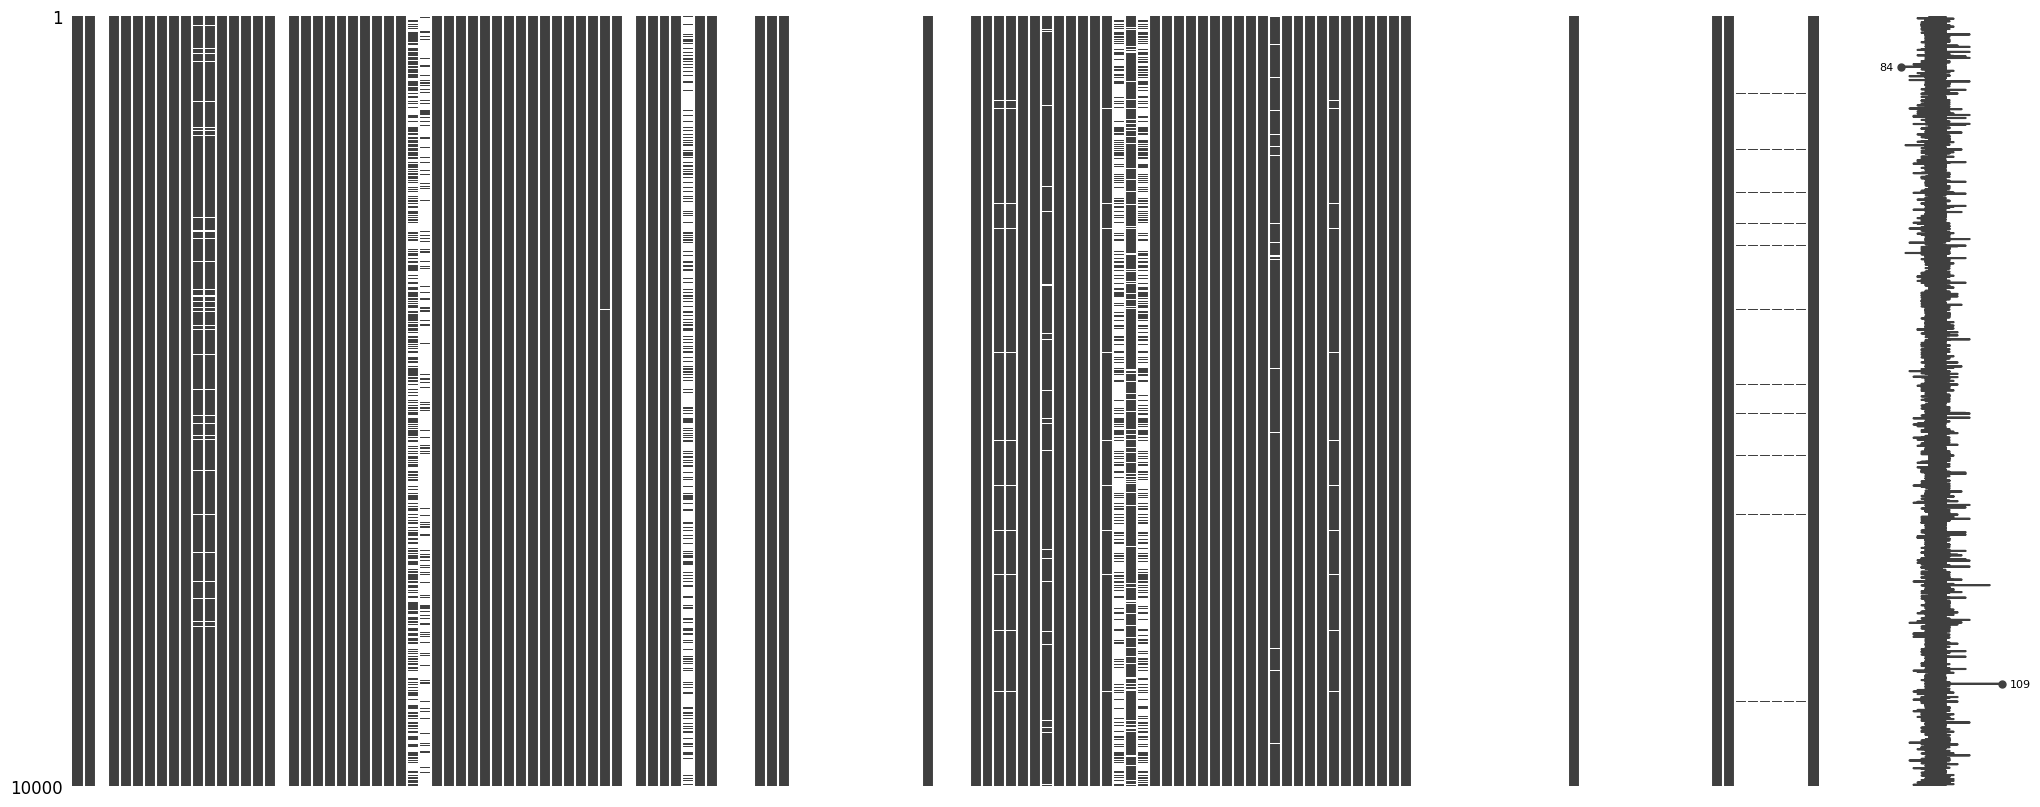

In [23]:
missings = auto.missing_values_analysis(train_data=all_train)

In [24]:
threshold = 90

# Get the columns that have a null percentage greater than the threshold
null_percentage = (all_train.isnull().sum() / len(all_train)) * 100
columns_to_drop = null_percentage[null_percentage > threshold].index
print(columns_to_drop)
# Drop the columns
a_train.drop(columns=columns_to_drop, inplace=True)
a_test.drop(columns=columns_to_drop, inplace=True)
a_val.drop(columns=columns_to_drop, inplace=True)
all_train.drop(columns=columns_to_drop, inplace=True)

Index(['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_start_date', 'hardship_end_date', 'hardship_length',
       'hardship_dpd', 'hardship_loan_status',
       'hardship_payoff_balance_amount', 'hardship_last_payment_am

**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50464.4835,28923.297905,1.0,25648.0,50357.5,75645.0,99995.0,int64,,,int,numeric,
acc_now_delinq,10000,3,,,0.0057,0.082875,0.0,0.0,0.0,0.0,2.0,float64,,,float,category,
acc_open_past_24mths,10000,26,,,4.6013,3.070941,0.0,2.0,4.0,6.0,42.0,float64,,,float,numeric,
addr_state,10000,46,CA,1437,,,,,,,,object,,,object,category,
annual_inc,10000,1443,,,73178.239042,47513.272586,4000.0,45000.0,62000.0,89000.0,900000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8039,,,13042.8875,15995.720627,0.0,2942.75,6934.0,18039.5,447433.0,float64,,,float,numeric,
bc_open_to_buy,9888,6859,,,8775.811792,14078.576055,0.0,1089.75,3739.5,10335.75,224525.0,float64,112,0.0112,float,numeric,
bc_util,9882,1048,,,63.870806,27.154072,0.0,44.1,68.15,87.4,141.2,float64,118,0.0118,float,numeric,
charged_off,10000,2,,,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


**`test_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50479.9819,28903.488769,12.0,25489.75,50174.5,75792.5,99999.0,int64,,,int,numeric,
acc_now_delinq,10000,5,,,0.0071,0.098237,0.0,0.0,0.0,0.0,4.0,float64,,,float,category,
acc_open_past_24mths,10000,27,,,4.5811,3.058195,0.0,2.0,4.0,6.0,39.0,float64,,,float,numeric,
addr_state,10000,46,CA,1471,,,,,,,,object,,,object,category,
annual_inc,10000,1429,,,73930.624622,52583.752854,6900.0,45000.0,62000.0,89000.0,1250000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8044,,,13374.1735,17152.44231,0.0,2991.0,6978.5,18252.25,278317.0,float64,,,float,numeric,
bc_open_to_buy,9883,6893,,,8916.250936,13863.52323,0.0,1089.0,3775.0,10620.0,225313.0,float64,117,0.0117,float,numeric,
bc_util,9878,1060,,,63.712533,27.051444,0.0,43.9,67.6,87.5,188.8,float64,122,0.0122,float,numeric,
charged_off,10000,2,,,0.189,0.391528,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


### Feature Distance

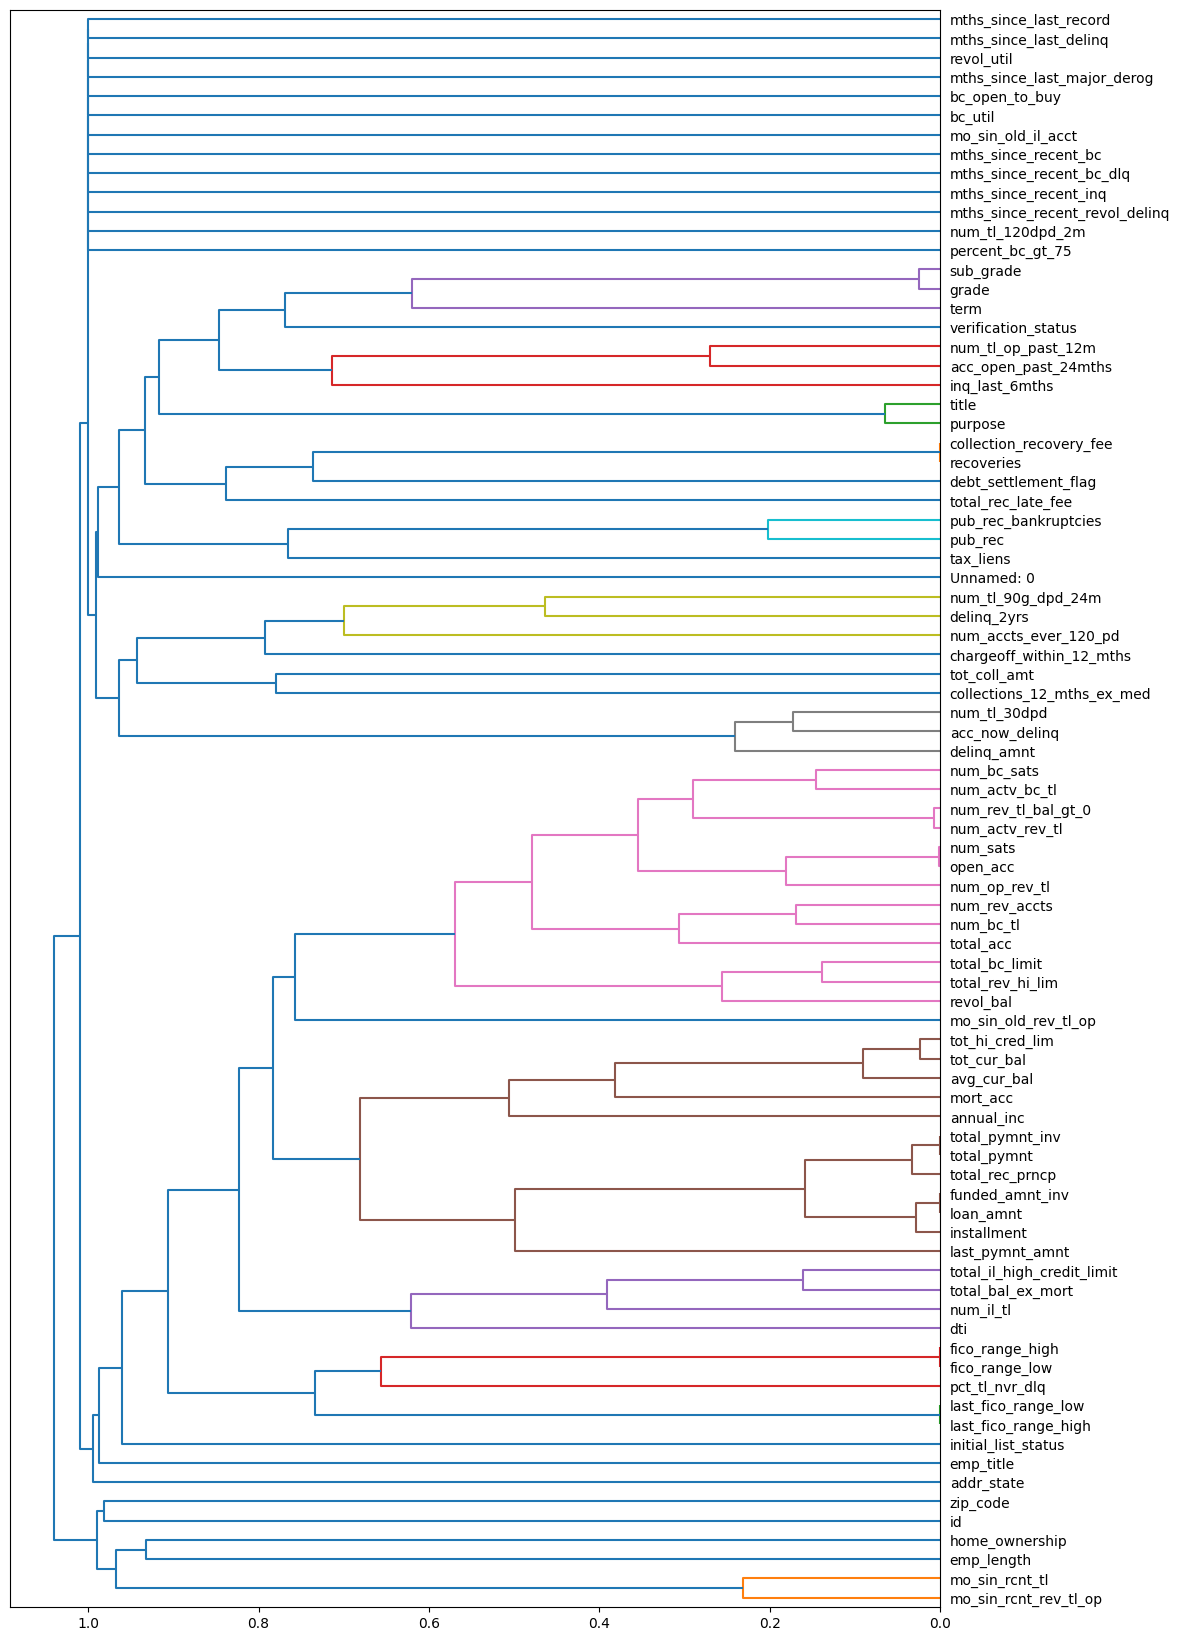

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `total_pymnt`, `total_pymnt_inv` - distance `0.00`
 - `fico_range_high`, `fico_range_low` - distance `0.00`
 - `last_fico_range_high`, `last_fico_range_low` - distance `0.00`
 - `funded_amnt_inv`, `loan_amnt` - distance `0.00`
 - `collection_recovery_fee`, `recoveries` - distance `0.00`
 - `num_sats`, `open_acc` - distance `0.00`
 - `num_actv_rev_tl`, `num_rev_tl_bal_gt_0` - distance `0.01`

Feature interaction between `total_pymnt`/`total_pymnt_inv`

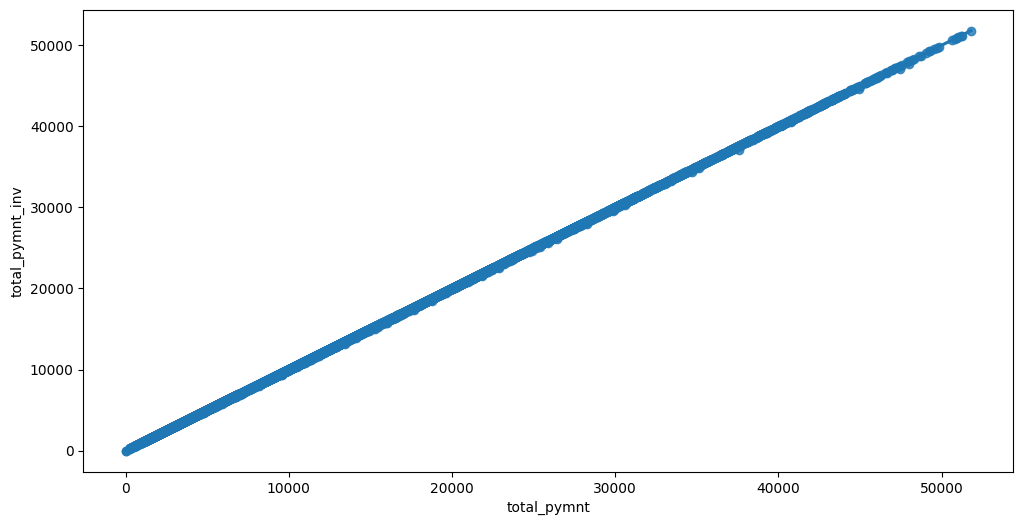

Feature interaction between `fico_range_high`/`fico_range_low`

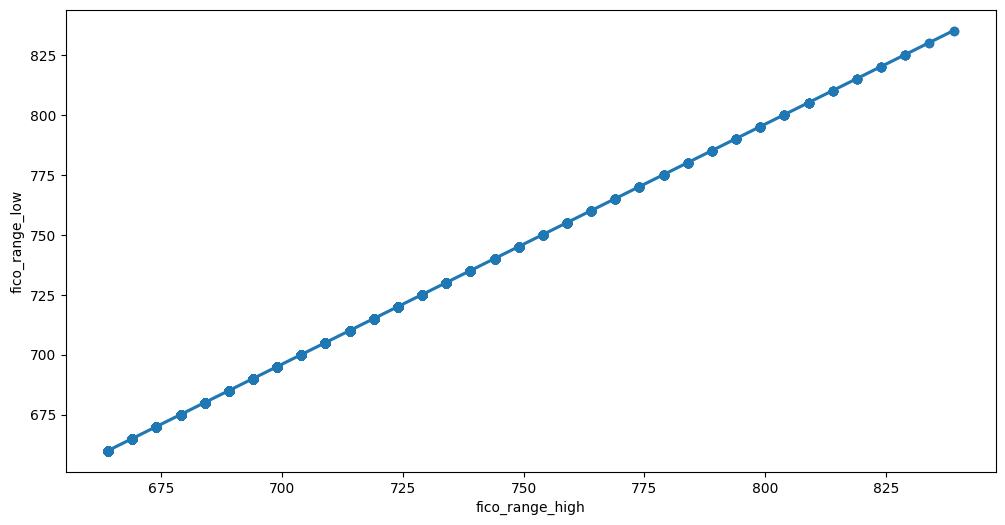

Feature interaction between `last_fico_range_high`/`last_fico_range_low`

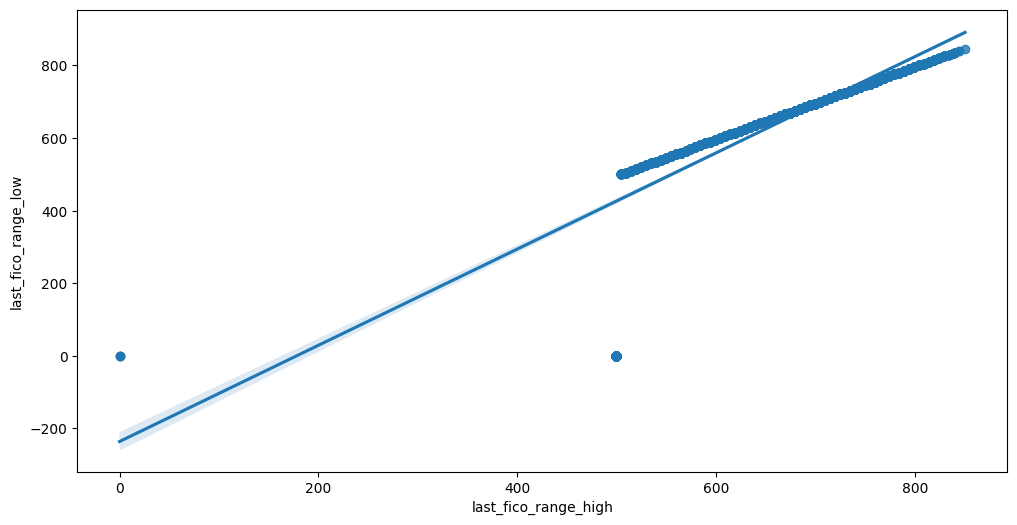

Feature interaction between `funded_amnt_inv`/`loan_amnt`

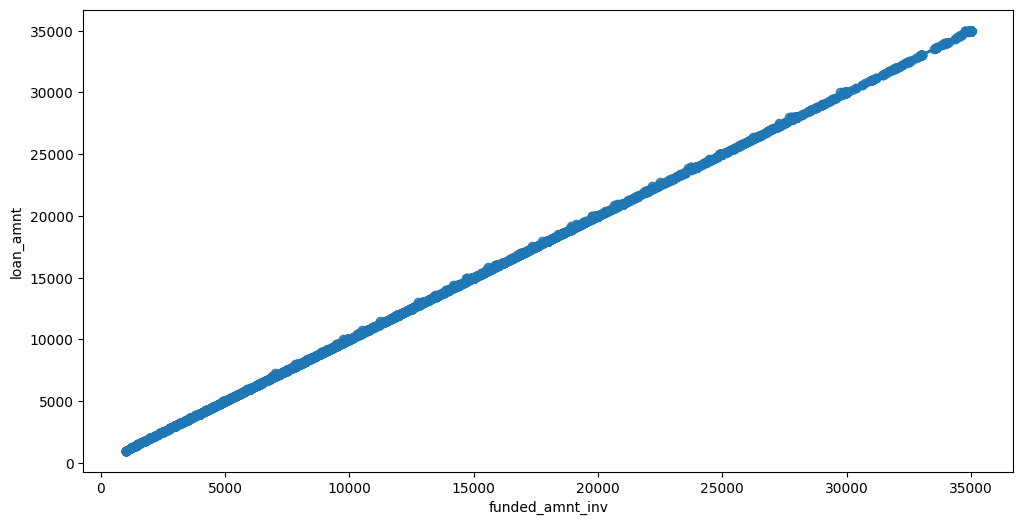

Feature interaction between `collection_recovery_fee`/`recoveries`

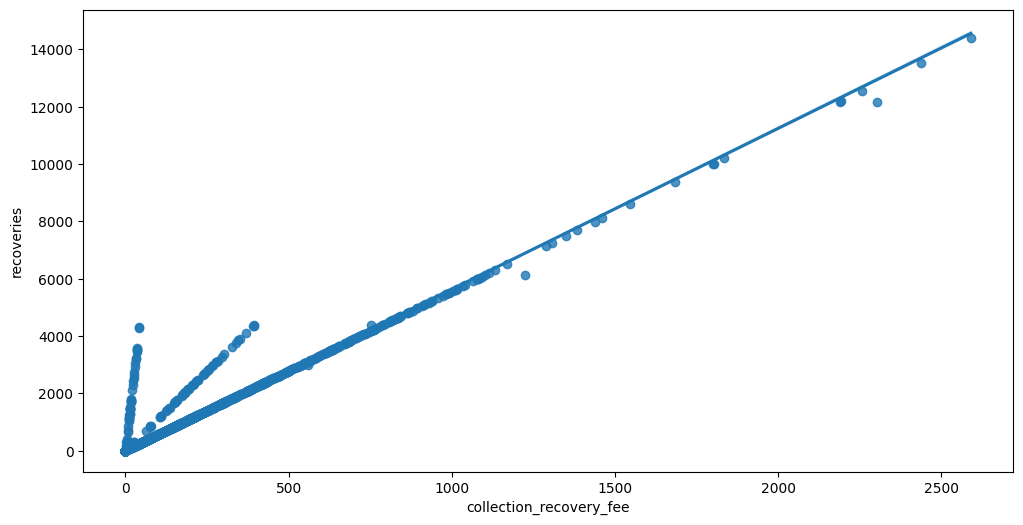

Feature interaction between `num_sats`/`open_acc`

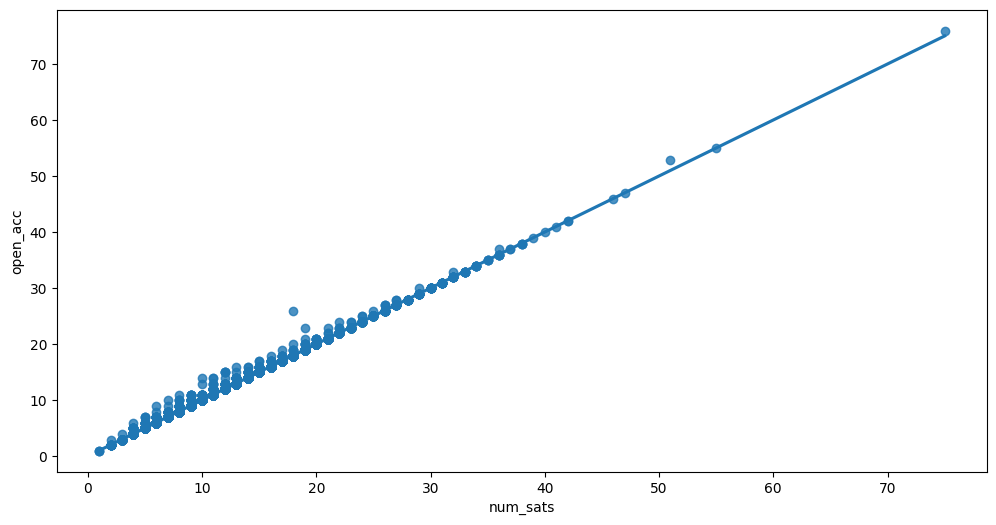

Feature interaction between `num_actv_rev_tl`/`num_rev_tl_bal_gt_0`

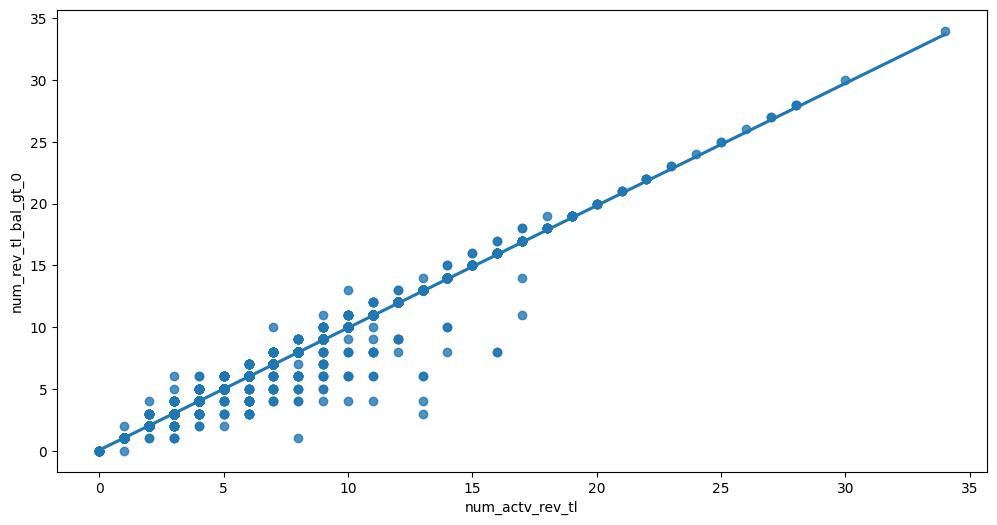

In [25]:
eda_overview = auto.dataset_overview(train_data=all_train, test_data=a_test, 
                      label='charged_off')

total_pymnt, total_pymnt_inv - distance 0.00
fico_range_high, fico_range_low - distance 0.00
last_fico_range_high, last_fico_range_low - distance 0.00
funded_amnt_inv, loan_amnt - distance 0.00
collection_recovery_fee, recoveries - distance 0.00
num_sats, open_acc - distance 0.00
num_actv_rev_tl, num_rev_tl_bal_gt_0 - distance 0.01

In [26]:
remove_columns_correlated = [
'total_pymnt', #total_pymnt_inv - distance 0.00
'fico_range_high', #fico_range_low - distance 0.00
'last_fico_range_high', #last_fico_range_low - distance 0.00
'funded_amnt_inv', #loan_amnt - distance 0.00
'collection_recovery_fee', #recoveries - distance 0.00
'num_sats', #open_acc - distance 0.00
'num_actv_rev_tl',# num_rev_tl_bal_gt_0 
]

In [27]:
a_train = a_train.drop(columns=remove_columns_correlated)
a_val = a_val.drop(columns=remove_columns_correlated)
a_test = a_test.drop(columns=remove_columns_correlated)
all_train = all_train.drop(columns=remove_columns_correlated)


## Target variable analysis

### Label Insights

 - Mild minority class imbalance detected - imbalance ratio is `22.40%`. Recommendations:
   - downsample majority class `0` to improve the balance
   - upweight downsampled class so that `sample_weight = original_weight x downsampling_factor`.[TabularPredictor](https://auto.gluon.ai/stable/api/autogluon.predictor.html#module-0) supports this via `sample_weight` parameter

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
charged_off,10000,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,2,,,int,


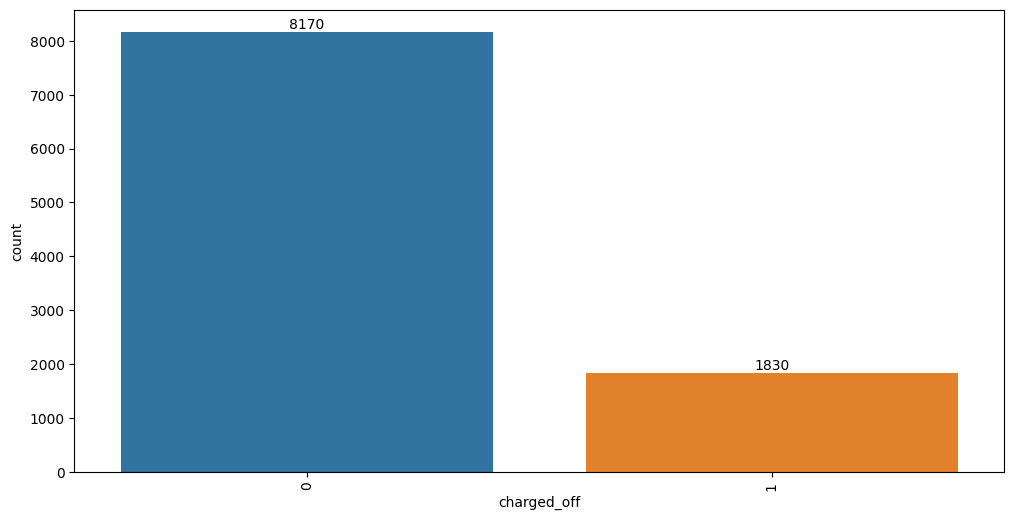

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `charged_off` >= `0.5` (sample size: 10000)**

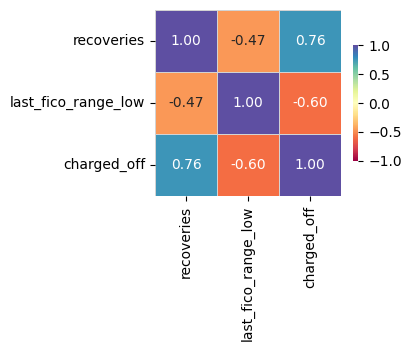

**Feature interaction between `recoveries`/`charged_off` in `train_data` (sample size: 10000)**

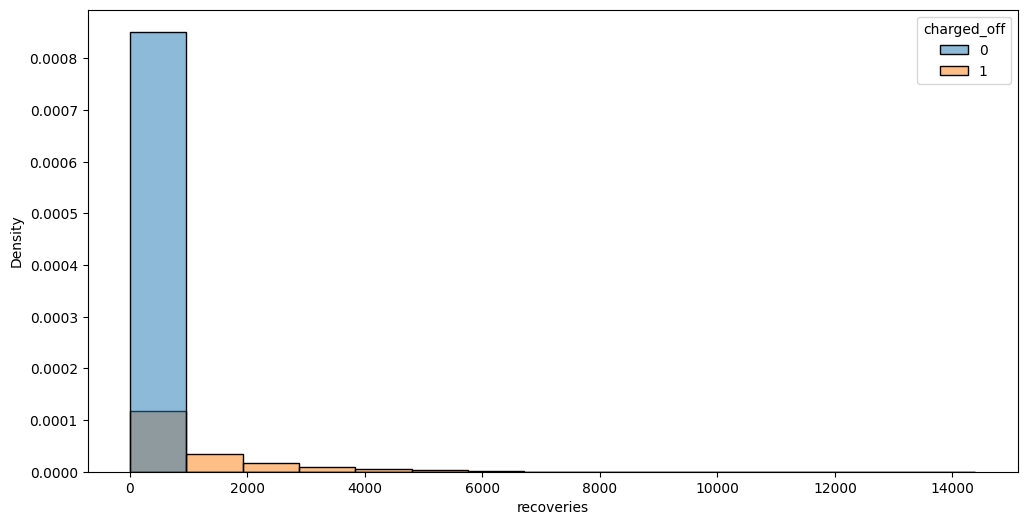

**Feature interaction between `last_fico_range_low`/`charged_off` in `train_data` (sample size: 10000)**

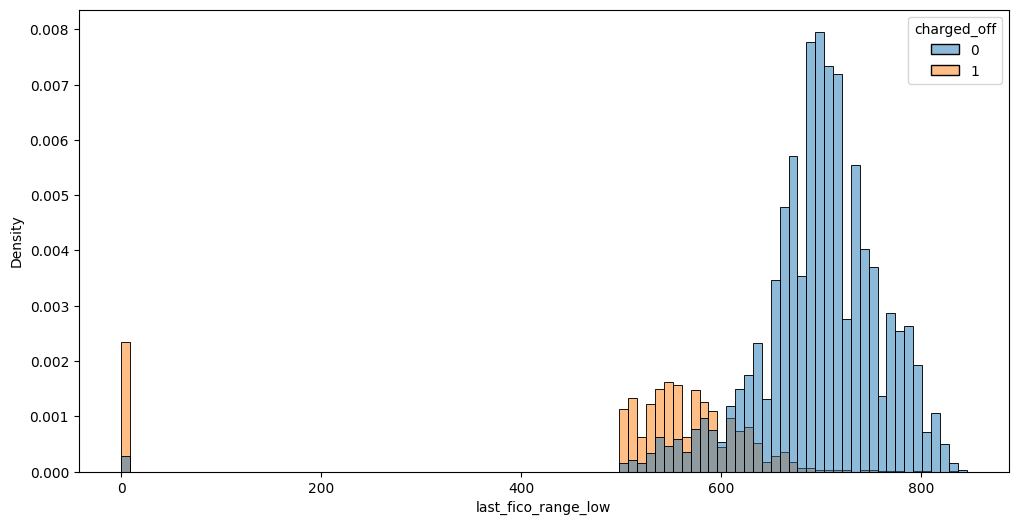

In [28]:
auto.target_analysis(train_data=all_train, label='charged_off')

### EDA Tasa de Interes

Asegura de que los datos sean robustos ante la tasa de interes.  
+ Que pasaria si historicamente el banco solo ha ofrecido uno, dos, o tres tipos de tasa de interes? Como limitaria esto tus recomendaciones? 
  + Piensa que si solo existen ciertos tipos de tasa de interes tus datos estan sesgados o condicionados a estas tasas de interes, por lo que proponer tasas diferentes a estas causaria problemas.  

Incluso si la muestra esta sesgada (o no), imagina que este problema no existe para el resto del Notebook


In [29]:
all_train_b = pd.concat([b_train,b_val], ignore_index=True).copy()

### Missing Values Analysis

,missing_count,missing_ratio
member_id,10000,1.0000
emp_title,531,0.0531
emp_length,530,0.0530
desc,10000,1.0000
mths_since_last_delinq,4818,0.4818
mths_since_last_record,8324,0.8324
revol_util,5,0.0005
last_pymnt_d,12,0.0012
next_pymnt_d,10000,1.0000
last_credit_pull_d,1,0.0001


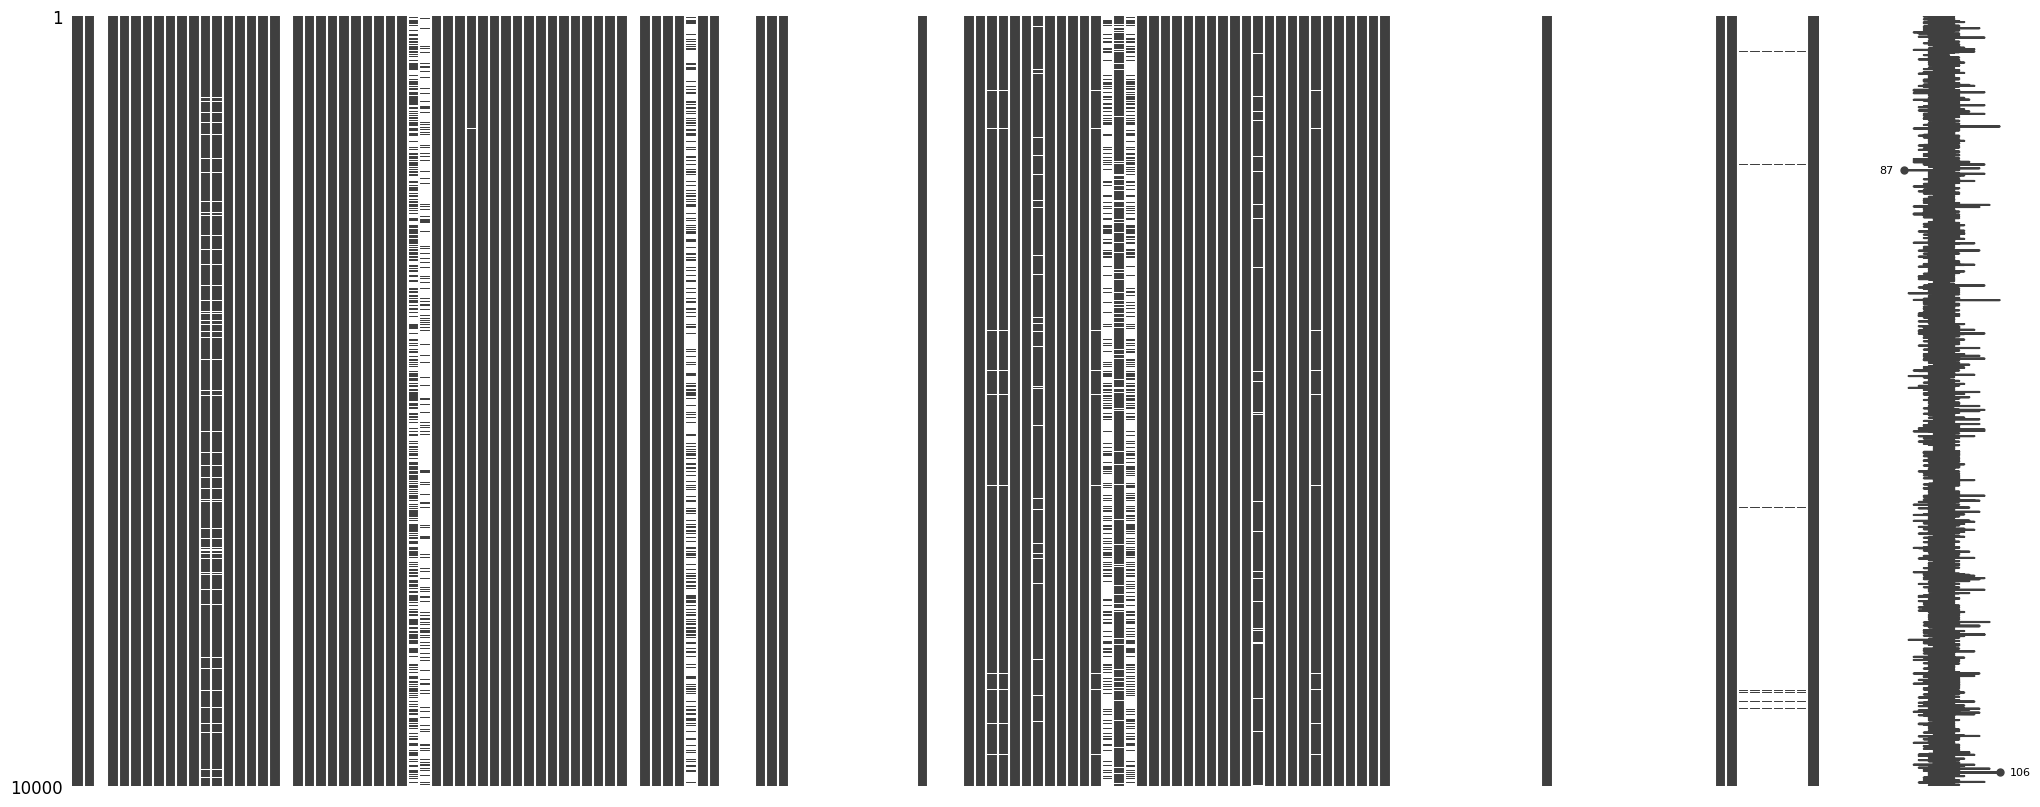

In [30]:
missings = auto.missing_values_analysis(train_data=all_train_b)

In [31]:
threshold = 90

# Get the columns that have a null percentage greater than the threshold
null_percentage = (all_train_b.isnull().sum() / len(all_train_b)) * 100
columns_to_drop = null_percentage[null_percentage > threshold].index
print(columns_to_drop)
# Drop the columns
b_train.drop(columns=columns_to_drop, inplace=True)
b_test.drop(columns=columns_to_drop, inplace=True)
b_val.drop(columns=columns_to_drop, inplace=True)
all_train_b.drop(columns=columns_to_drop, inplace=True)

Index(['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_project

**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50718.0708,28883.905849,34.0,25551.75,50715.0,75850.5,99989.0,int64,,,int,numeric,
acc_now_delinq,10000,4,,,0.0076,0.093505,0.0,0.0,0.0,0.0,3.0,float64,,,float,category,
acc_open_past_24mths,10000,26,,,4.5811,3.055185,0.0,2.0,4.0,6.0,29.0,float64,,,float,numeric,
addr_state,10000,46,CA,1425,,,,,,,,object,,,object,category,
annual_inc,10000,1476,,,74483.425222,51304.512992,4000.0,45000.0,63000.0,90000.0,960000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8117,,,13148.4233,16385.256572,0.0,3039.0,7141.0,18002.75,446720.0,float64,,,float,numeric,
bc_open_to_buy,9879,6880,,,8922.783885,14038.180973,0.0,1072.0,3878.0,10593.0,192017.0,float64,121,0.0121,float,numeric,
bc_util,9875,1057,,,63.835818,27.163593,0.0,44.1,67.9,87.5,136.0,float64,125,0.0125,float,numeric,
charged_off,10000,2,,,0.1873,0.390172,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


**`test_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50791.7588,28749.847515,4.0,26347.0,50753.5,76027.75,99995.0,int64,,,int,numeric,
acc_now_delinq,10000,3,,,0.0051,0.072626,0.0,0.0,0.0,0.0,2.0,float64,,,float,category,
acc_open_past_24mths,10000,26,,,4.5526,2.993782,0.0,2.0,4.0,6.0,31.0,float64,,,float,numeric,
addr_state,10000,46,CA,1440,,,,,,,,object,,,object,category,
annual_inc,10000,1435,,,72765.187695,47199.818936,7452.0,45000.0,62000.0,88425.0,1100000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8090,,,13164.9117,16040.210178,0.0,3047.5,7131.5,17970.0,307805.0,float64,,,float,numeric,
bc_open_to_buy,9877,6927,,,8964.788296,14174.0986,0.0,1120.0,3874.0,10462.0,225313.0,float64,123,0.0123,float,numeric,
bc_util,9874,1050,,,63.478195,27.10684,0.0,43.1,67.15,87.4,180.3,float64,126,0.0126,float,numeric,
charged_off,10000,2,,,0.1879,0.390652,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


### Feature Distance

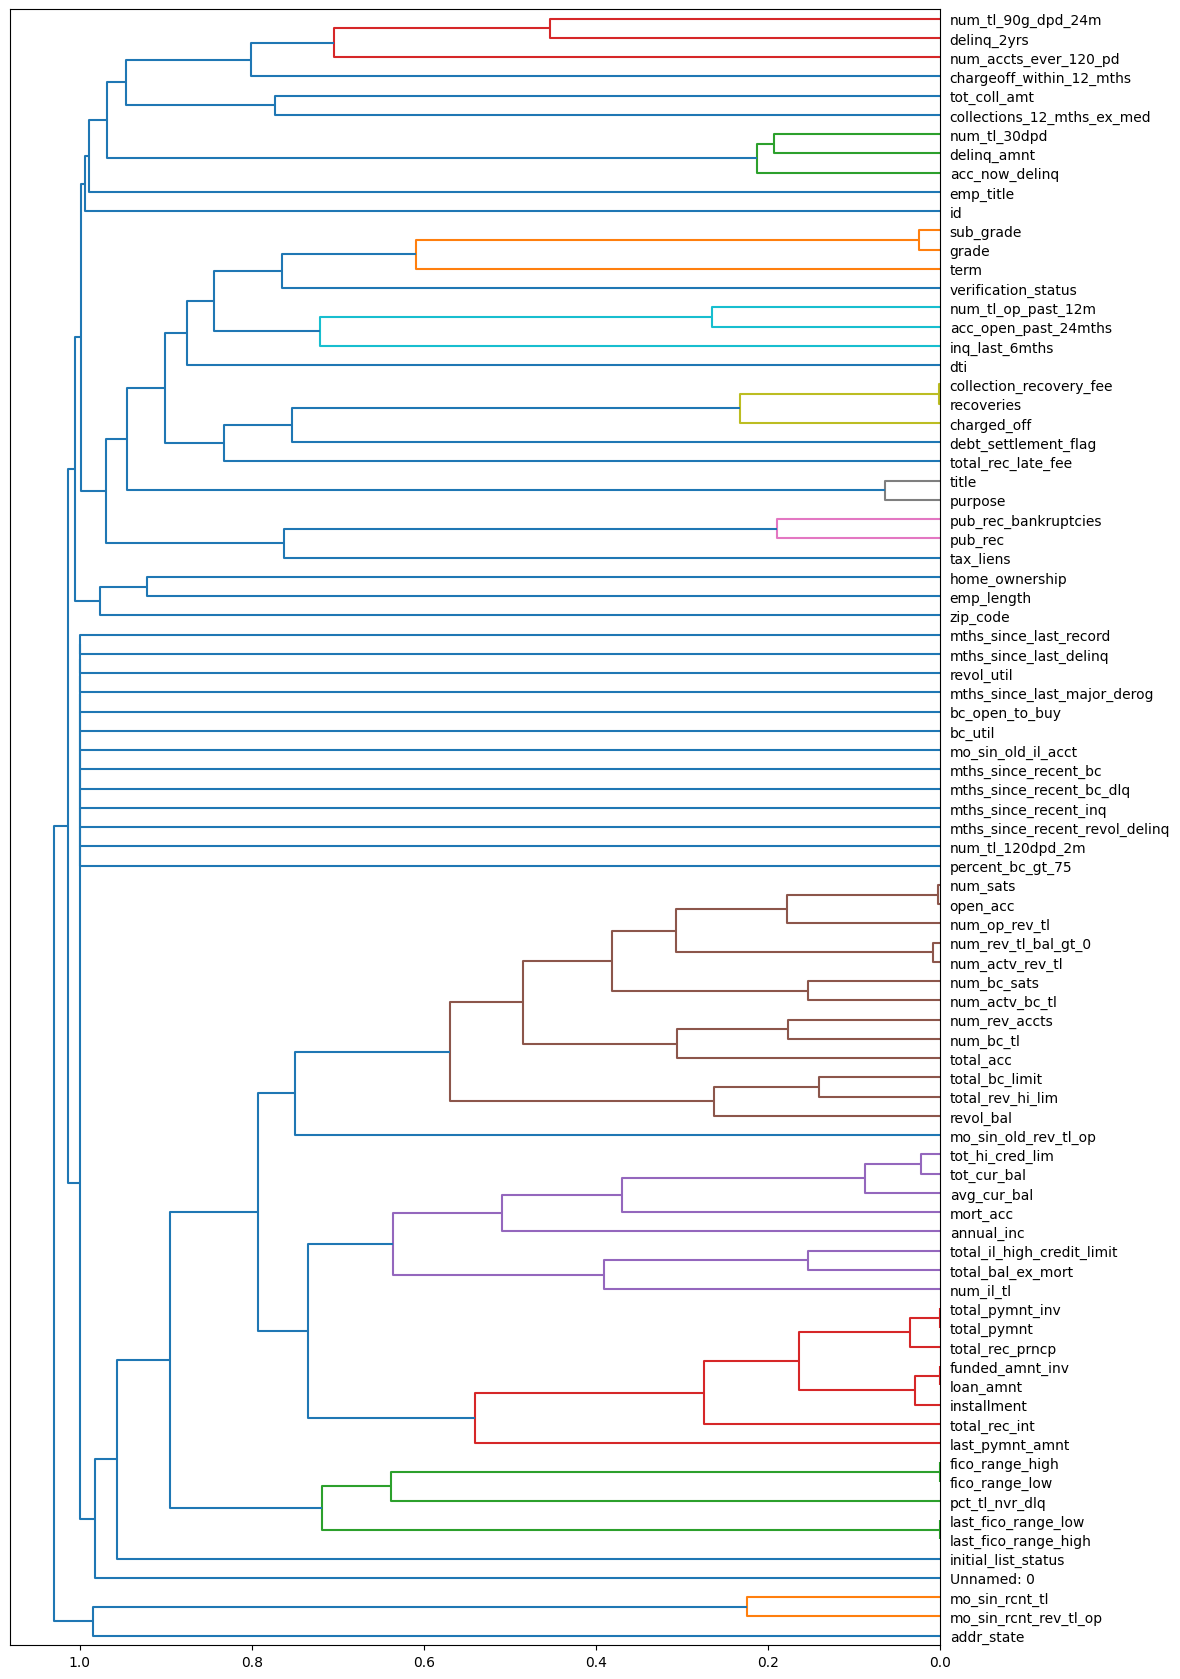

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `total_pymnt`, `total_pymnt_inv` - distance `0.00`
 - `fico_range_high`, `fico_range_low` - distance `0.00`
 - `last_fico_range_high`, `last_fico_range_low` - distance `0.00`
 - `funded_amnt_inv`, `loan_amnt` - distance `0.00`
 - `collection_recovery_fee`, `recoveries` - distance `0.00`
 - `num_sats`, `open_acc` - distance `0.00`
 - `num_actv_rev_tl`, `num_rev_tl_bal_gt_0` - distance `0.01`

Feature interaction between `total_pymnt`/`total_pymnt_inv`

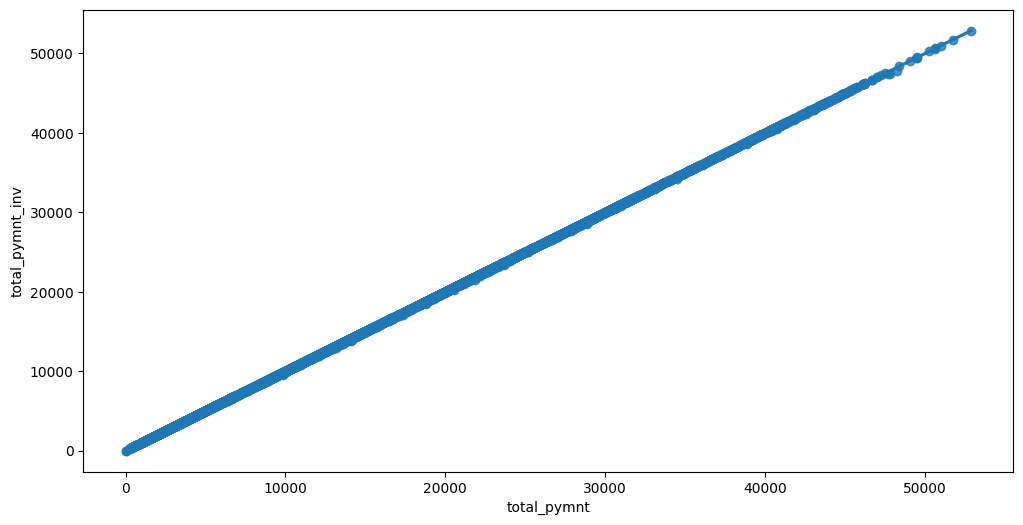

Feature interaction between `fico_range_high`/`fico_range_low`

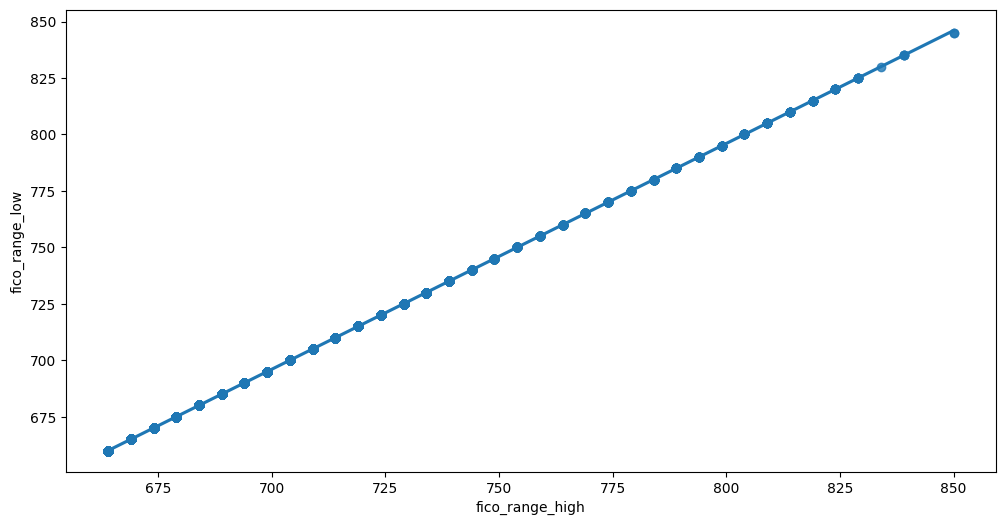

Feature interaction between `last_fico_range_high`/`last_fico_range_low`

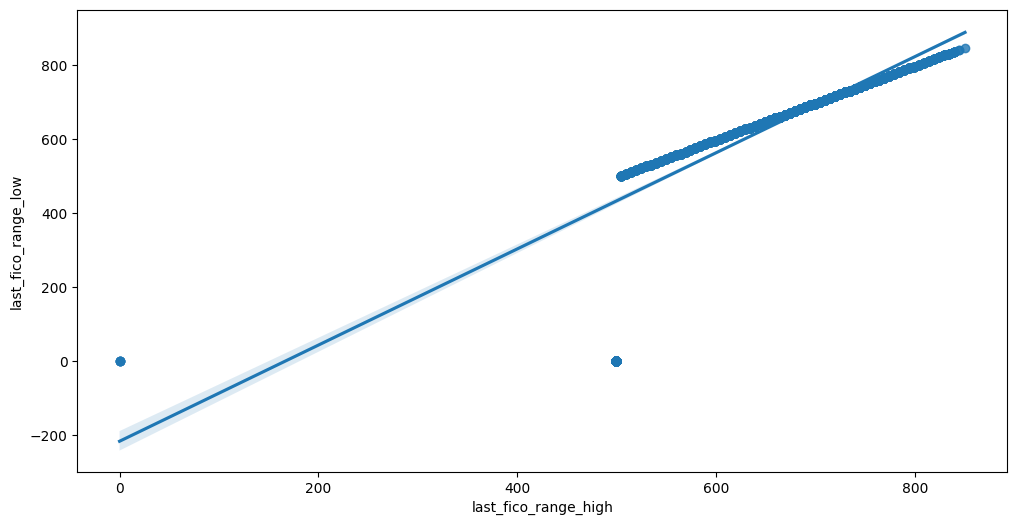

Feature interaction between `funded_amnt_inv`/`loan_amnt`

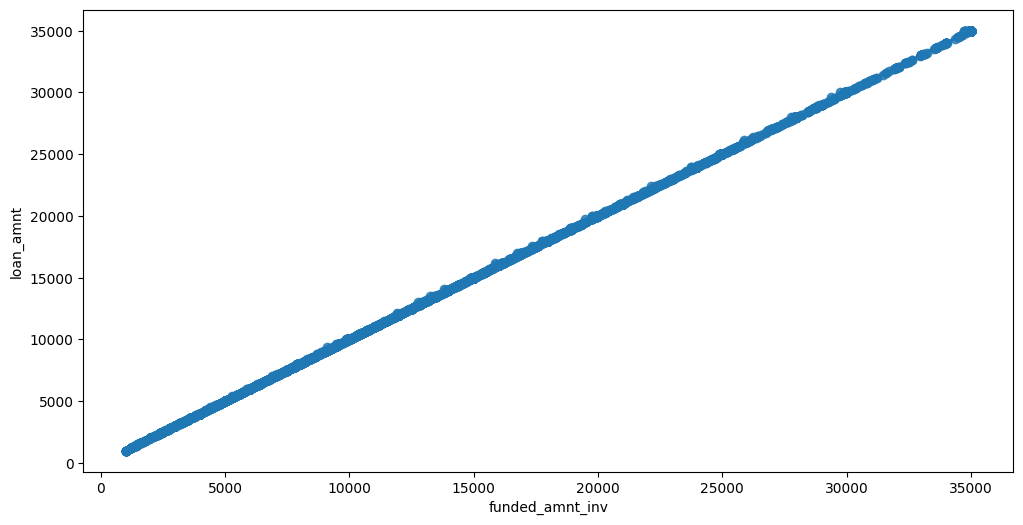

Feature interaction between `collection_recovery_fee`/`recoveries`

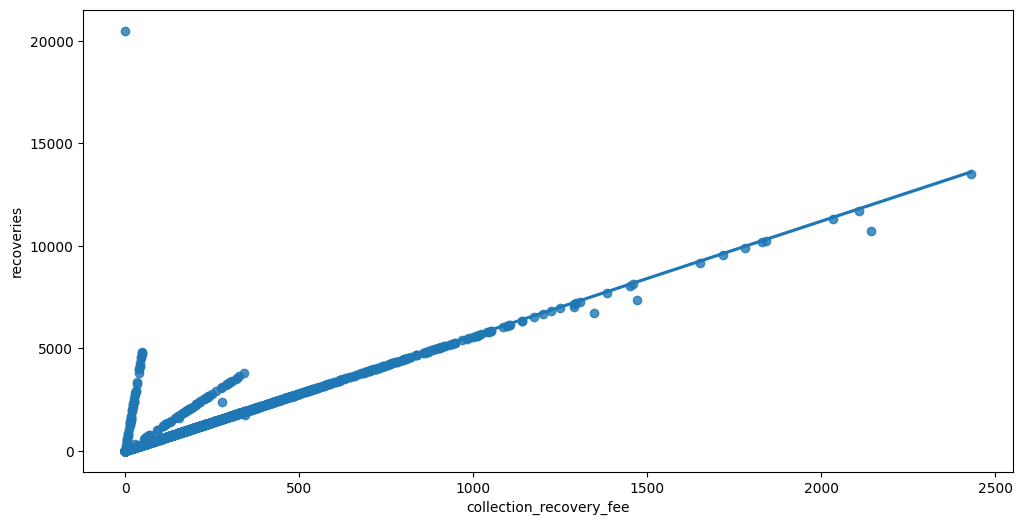

Feature interaction between `num_sats`/`open_acc`

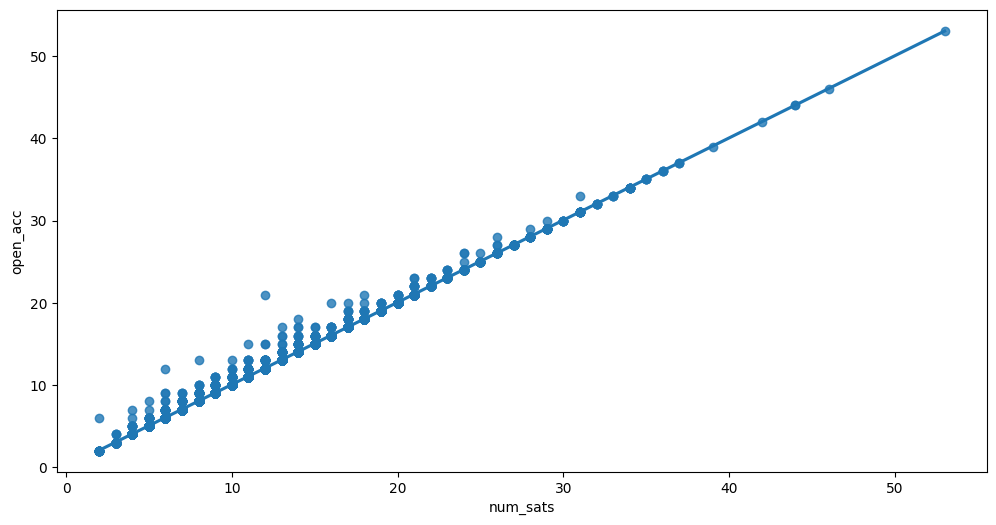

Feature interaction between `num_actv_rev_tl`/`num_rev_tl_bal_gt_0`

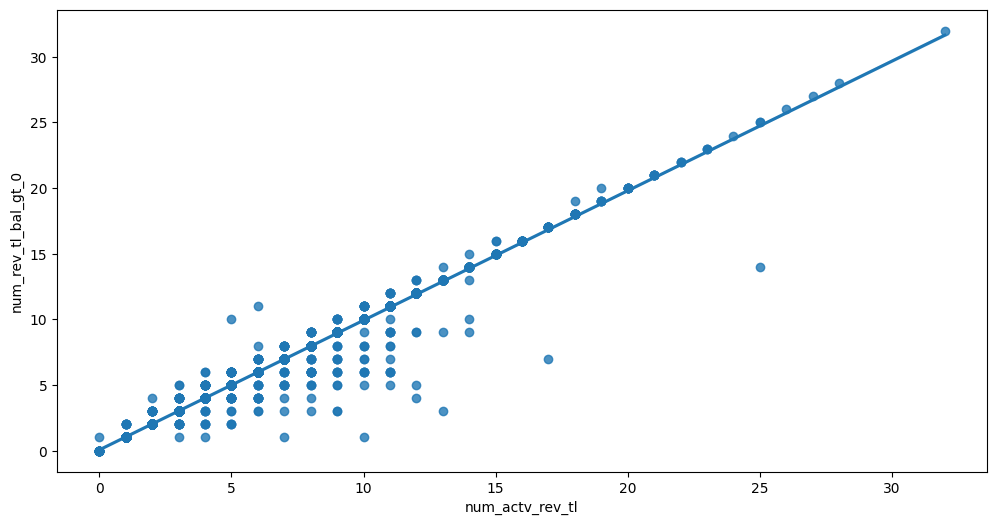

In [32]:
eda_overview = auto.dataset_overview(train_data=all_train_b, test_data=b_test, 
                      label='int_rate')

In [33]:
remove_columns_correlated = [
'total_pymnt', #total_pymnt_inv - distance 0.00
'fico_range_high', #fico_range_low - distance 0.00
'last_fico_range_high', #last_fico_range_low - distance 0.00
'funded_amnt_inv', #loan_amnt - distance 0.00
'collection_recovery_fee', #recoveries - distance 0.00
'num_sats', #open_acc - distance 0.00
'num_actv_rev_tl',# num_rev_tl_bal_gt_0 
]

In [34]:
b_train = b_train.drop(columns=remove_columns_correlated)
b_val = b_val.drop(columns=remove_columns_correlated)
b_test = b_test.drop(columns=remove_columns_correlated)
all_train_b = all_train_b.drop(columns=remove_columns_correlated)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
int_rate,10000,12.993409,4.382967,6.0,9.49,12.99,15.61,26.06,float64,58,,,float,


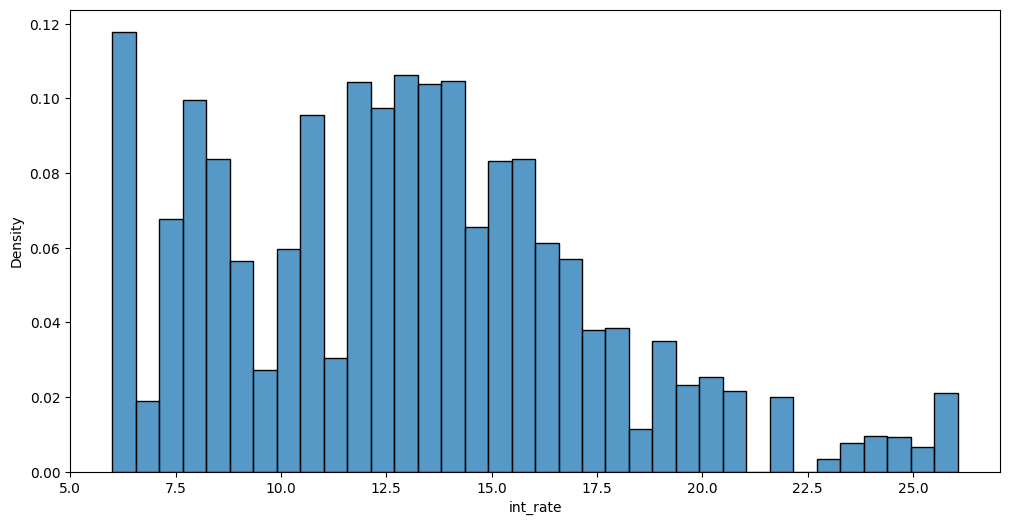

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `int_rate` >= `0.5` (sample size: 10000)**

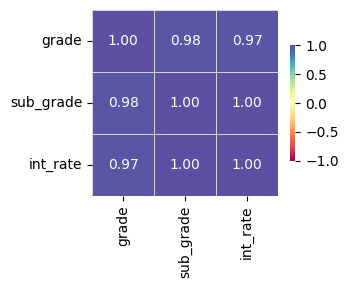

Interaction `sub_grade`/`int_rate` is not rendered due to `sub_grade` having too many categories (`35` > `30`) to place on plot axis.

**Feature interaction between `grade`/`int_rate` in `train_data` (sample size: 10000)**

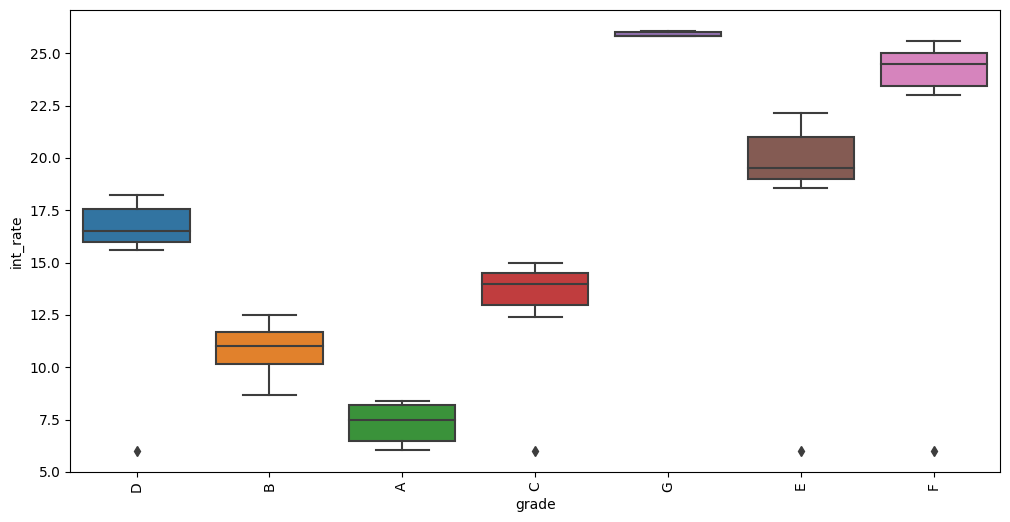

In [35]:
auto.target_analysis(train_data=all_train_b, label='int_rate')

### Training

In [36]:
auto.covariate_shift_detection(train_data=all_train, test_data=a_test, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

In [37]:
auto.covariate_shift_detection(train_data=a_train, test_data=a_val, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

No path specified. Models will be saved in: "AutogluonModels/ag-20231123_020439/"


### Model Prediction for charged_off

Using validation data for `Test` points

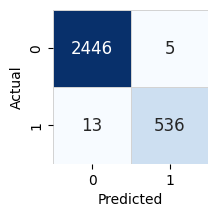

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.994,0.997143,0.015589,0.006237,1.83724,0.015589,0.006237,1.83724,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
last_pymnt_amnt,0.055933,0.001623,8.492252e-08,5,0.059275,0.052592
recoveries,0.052000,0.002593,7.391889e-07,5,0.057338,0.046662
last_fico_range_low,0.042133,0.001574,2.333431e-07,5,0.045374,0.038892
last_pymnt_d,0.024933,0.001256,7.703416e-07,5,0.027520,0.022347
total_rec_prncp,0.016533,0.000606,2.155292e-07,5,0.017780,0.015287
term,0.010333,0.001616,6.947701e-05,5,0.013660,0.007006
installment,0.003867,0.000901,3.290151e-04,5,0.005721,0.002012
loan_amnt,0.002733,0.001090,2.487367e-03,5,0.004978,0.000488
debt_settlement_flag,0.001800,0.000730,2.644312e-03,5,0.003304,0.000296
last_credit_pull_d,0.000733,0.000548,2.009311e-02,5,0.001861,-0.000394


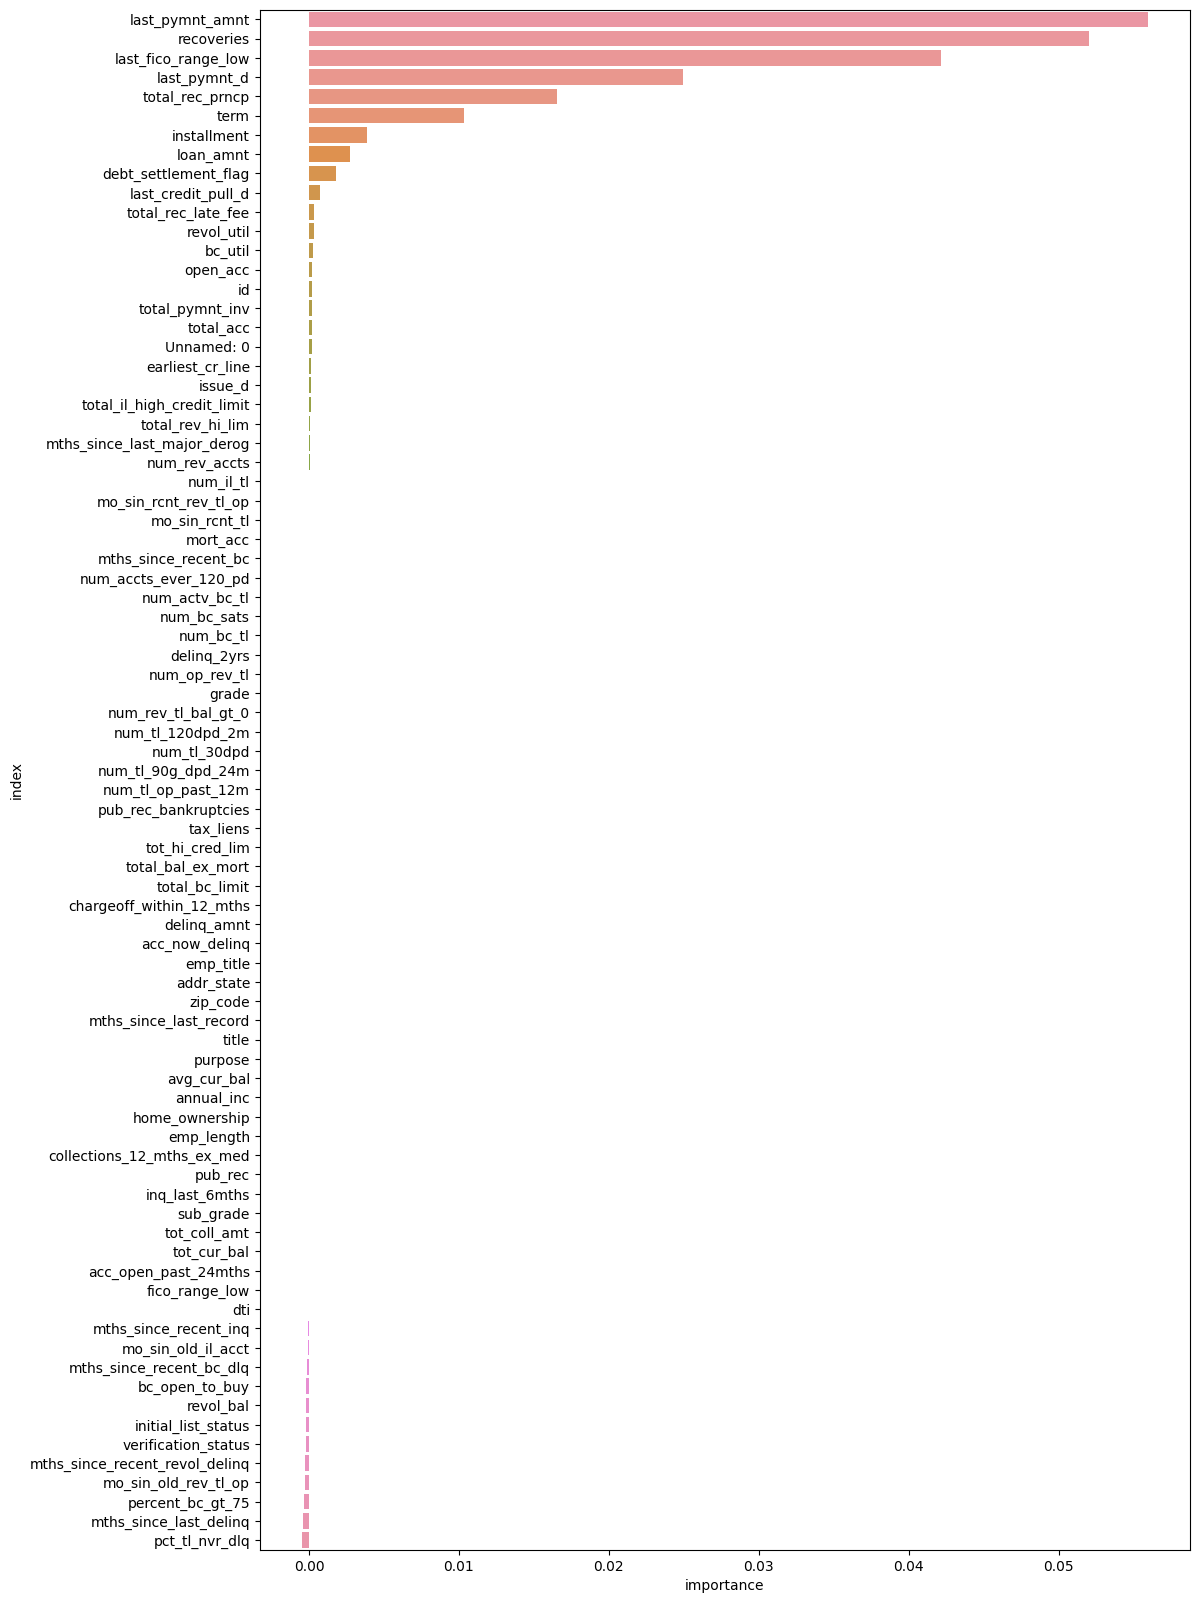

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,14364.0,9900.0,6500.0,N,Cash,N,1,0.981394,0.018606,0.962788
2838,94757,24144490,14000.0,14000.0,60 months,325.62,C,C3,None,None,...,33990.0,5000.0,35260.0,N,Cash,N,1,0.956333,0.043667,0.912667
38733,80439,26260391,9225.0,9225.0,36 months,322.56,D,D1,None,None,...,13665.0,49600.0,0.0,N,Cash,N,1,0.953058,0.046942,0.906116
68256,50892,30996120,8650.0,8650.0,36 months,308.36,D,D3,Manager,10+ years,...,18763.0,2200.0,21708.0,N,Cash,N,1,0.925013,0.074987,0.850026
60074,93947,464181,13000.0,13000.0,36 months,450.59,C,C5,Administrative Specialist II,1 year,...,16001.0,27100.0,0.0,N,Cash,N,0,0.183094,0.816906,0.633811
35237,62284,29254321,9000.0,9000.0,36 months,309.75,C,C4,sales associate,1 year,...,6787.0,4400.0,3010.0,N,Cash,N,1,0.805195,0.194805,0.610391
61886,44670,31537866,10500.0,10500.0,36 months,351.22,B,B5,None,None,...,16709.0,3000.0,19036.0,N,Cash,N,1,0.793721,0.206279,0.587443
22632,51941,30756075,9600.0,9600.0,36 months,306.04,B,B1,Account Representative,10+ years,...,29539.0,5800.0,25688.0,N,Cash,N,1,0.780893,0.219107,0.561785
11496,46215,31567205,12600.0,12600.0,36 months,461.81,E,E1,Account Manager,< 1 year,...,37840.0,16400.0,31500.0,N,Cash,N,0,0.240642,0.759358,0.518715
59403,29058,34392060,30000.0,30000.0,60 months,658.88,B,B4,Manager Managed Care Contracting,10+ years,...,34739.0,20900.0,35801.0,N,Cash,N,1,0.755711,0.244289,0.511422


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,charged_off,0,1,error
28593,16617,35338360,8850.0,8850.0,36 months,322.36,E,E1,None,None,...,95698.0,4200.0,115009.0,N,Cash,N,1,0.518873,0.481127,0.037746
55947,44304,31227651,6000.0,6000.0,36 months,203.18,C,C2,Laboratory,4 years,...,27671.0,4100.0,31434.0,N,Cash,N,1,0.528504,0.471496,0.057008
57405,96281,21100461,18900.0,18900.0,60 months,511.21,E,E4,Manager,8 years,...,42164.0,6300.0,43598.0,N,Cash,N,1,0.531175,0.468825,0.062350
67807,40322,29453909,21600.0,21600.0,36 months,698.50,B,B2,Financial Managment Analyst II,10+ years,...,60906.0,29200.0,45541.0,N,Cash,N,0,0.428997,0.571003,0.142007
53117,88257,24865158,8000.0,8000.0,36 months,264.46,B,B4,nanny,10+ years,...,24083.0,13000.0,16248.0,N,Cash,N,0,0.408629,0.591371,0.182741
26710,34264,33130799,15000.0,15000.0,36 months,491.01,B,B3,Associate Analyst,7 years,...,33687.0,23500.0,19075.0,N,Cash,N,0,0.379736,0.620264,0.240529
17397,1426,37670606,8975.0,8975.0,36 months,320.61,D,D4,Owner,3 years,...,27447.0,4000.0,41051.0,N,Cash,N,1,0.687351,0.312649,0.374702
14245,60135,29664395,25000.0,25000.0,36 months,779.84,A,A4,System Engineer,4 years,...,38489.0,64700.0,23663.0,N,Cash,N,1,0.751306,0.248694,0.502611
59403,29058,34392060,30000.0,30000.0,60 months,658.88,B,B4,Manager Managed Care Contracting,10+ years,...,34739.0,20900.0,35801.0,N,Cash,N,1,0.755711,0.244289,0.511422
11496,46215,31567205,12600.0,12600.0,36 months,461.81,E,E1,Account Manager,< 1 year,...,37840.0,16400.0,31500.0,N,Cash,N,0,0.240642,0.759358,0.518715


In [38]:
state = auto.quick_fit(
    all_train, 
    'charged_off', 
    return_state=True,
    show_feature_importance_barplots=True
)

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,14364.0,9900.0,6500.0,N,Cash,N,1,0.981394,0.018606,0.962788


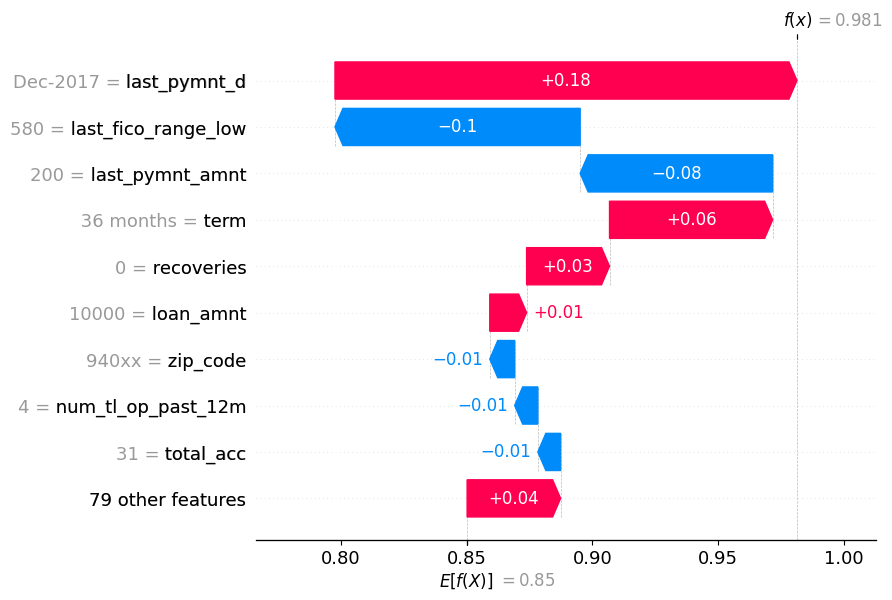

In [39]:
auto.explain_rows(
    train_data=all_train,
    model=state.model,
    display_rows=True,
    plot='waterfall',
    rows=state.model_evaluation.highest_error[:1]
)

In [40]:
save_path = 'AutogluonModels'


predictor = TabularPredictor(label='charged_off', path=save_path, 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar
                             sample_weight='balance_weight' # Pesos a a la funcion de perdida
                             )

In [41]:
predictor_val = TabularPredictor(label='charged_off', path=os.path.join(save_path,'validation'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='medium_quality',
                                 num_cpus = 16,
                                 tuning_data = a_val,
                                 hyperparameters = {
                                'NN_TORCH': {"num_epochs": 10, "learning_rate": 0.1},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                'CAT': {},
                                'XGB': {},
                                'FASTAI': {},
                                'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                'LR': {},
                                'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                       {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['medium_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/validation/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct 5 21:02:42 UTC 2023
Disk Space Avail:   1005.09 GB / 1081.10 GB (93.0%)
Train Data Rows:    55128
Train Data Columns: 88
Tuning Data Rows:    13782
Tuning Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights to balance differences in frequency of c

In [42]:
predictor_val.feature_importance(a_val)

These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 80 features using 5000 rows with 5 shuffle sets...
	63.23s	= Expected runtime (12.65s per shuffle set)
	26.81s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
total_rec_prncp,0.597253,0.029325,6.952285e-07,5,0.657634,0.536871
loan_amnt,0.310144,0.014326,5.446775e-07,5,0.339641,0.280648
recoveries,0.293680,0.014876,7.874014e-07,5,0.324311,0.263049
last_pymnt_amnt,0.064739,0.004342,2.413852e-06,5,0.073679,0.055799
last_fico_range_low,0.017008,0.003362,1.740520e-04,5,0.023930,0.010085
...,...,...,...,...,...,...
pct_tl_nvr_dlq,-0.000022,0.000038,8.683947e-01,5,0.000055,-0.000099
dti,-0.000022,0.000038,8.663706e-01,5,0.000056,-0.000100
num_op_rev_tl,-0.000025,0.000014,9.915366e-01,5,0.000004,-0.000054
total_il_high_credit_limit,-0.000029,0.000018,9.879170e-01,5,0.000009,-0.000066


In [43]:
predictor_val.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                  model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   -0.002118  0.998095           0.998453  0.998450   1.000000  0.999993  -0.002118        0.145899       0.126048   25.593681                 0.003601                0.000809           0.578490            2       True         14
1               XGBoost   -0.002413  0.998095           0.998601  0.998451   0.999612  0.999991  -0.002413        0.085262       0.078218   21.244629                 0.085262                0.078218          21.244629            1       True         10
2              LightGBM   -0.002446  0.998333           0.998646  0.998644   1.000000  0.999994  -0.002446        0.057036       0.047021    3.770562                 0.057036                0.047021           3.770562            1       True

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.002118,0.998095,0.998453,0.998450,1.000000,0.999993,-0.002118,0.145899,0.126048,25.593681,0.003601,0.000809,0.578490,2,True,14
1,XGBoost,-0.002413,0.998095,0.998601,0.998451,0.999612,0.999991,-0.002413,0.085262,0.078218,21.244629,0.085262,0.078218,21.244629,1,True,10
2,LightGBM,-0.002446,0.998333,0.998646,0.998644,1.000000,0.999994,-0.002446,0.057036,0.047021,3.770562,0.057036,0.047021,3.770562,1,True,4
3,CatBoost,-0.003815,0.996666,0.998185,0.997291,0.997677,0.999987,-0.003815,0.088141,0.043432,283.899296,0.088141,0.043432,283.899296,1,True,7
4,LightGBMLarge,-0.004428,0.996188,0.997500,0.996900,0.998448,0.999976,-0.004428,0.047530,0.038287,4.015994,0.047530,0.038287,4.015994,1,True,13
5,LightGBMXT,-0.005522,0.994282,0.996697,0.995352,0.996510,0.999973,-0.005522,0.154140,0.076211,4.796956,0.154140,0.076211,4.796956,1,True,3
6,LinearModel,-0.012917,0.987853,0.993706,0.990130,0.990705,0.999904,-0.012917,0.148006,0.148808,15.142382,0.148006,0.148808,15.142382,1,True,11
7,RandomForestEntr,-0.031088,0.986156,0.989674,0.988681,0.997637,0.999852,-0.031088,0.189169,0.129471,4.160677,0.189169,0.129471,4.160677,1,True,6
8,RandomForestGini,-0.032689,0.984962,0.988558,0.987688,0.998025,0.999876,-0.032689,0.201634,0.128057,4.353286,0.201634,0.128057,4.353286,1,True,5
9,ExtraTreesEntr,-0.074696,0.956612,0.965883,0.963807,0.997517,0.999332,-0.074696,0.359571,0.149969,2.839939,0.359571,0.149969,2.839939,1,True,9


### Modelo Interpretable

In [44]:
predictor_inter = TabularPredictor(label='charged_off', path=os.path.join(save_path,'Interpretable'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='best_quality',
                                 num_cpus = 16,
                                 included_model_types=['XGB']
                                )

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/Interpretable/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct 5 21:02:42 UTC 2023
Disk Space Avail:   1005.09 GB / 1081.10 GB (93.0%)
Train Data Rows:    55128
Train Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights

In [45]:
predictor_inter.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                 model  score_test      mcc  balanced_accuracy       f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       XGBoost_BAG_L1   -0.002798  0.99738           0.998319  0.99787   0.998837  0.999989  -0.005136        0.740196       0.326286  88.541142                 0.740196                0.326286          88.541142            1       True          1
1  WeightedEnsemble_L2   -0.002814  0.99738           0.998319  0.99787   0.998837  0.999989  -0.005136        0.742975       0.327588  88.544561                 0.002779                0.001302           0.003420            2       True          2


,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,-0.002798,0.99738,0.998319,0.99787,0.998837,0.999989,-0.005136,0.740196,0.326286,88.541142,0.740196,0.326286,88.541142,1,True,1
1,WeightedEnsemble_L2,-0.002814,0.99738,0.998319,0.99787,0.998837,0.999989,-0.005136,0.742975,0.327588,88.544561,0.002779,0.001302,0.003420,2,True,2


In [46]:
predictor_inter.leaderboard(a_test, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                 model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       XGBoost_BAG_L1   -0.003404  0.995806           0.997191  0.996589   0.998447  0.999978  -0.005136        0.891636       0.326286  88.541142                 0.891636                0.326286          88.541142            1       True          1
1  WeightedEnsemble_L2   -0.003417  0.995806           0.997191  0.996589   0.998447  0.999978  -0.005136        0.895394       0.327588  88.544561                 0.003758                0.001302           0.003420            2       True          2


,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,-0.003404,0.995806,0.997191,0.996589,0.998447,0.999978,-0.005136,0.891636,0.326286,88.541142,0.891636,0.326286,88.541142,1,True,1
1,WeightedEnsemble_L2,-0.003417,0.995806,0.997191,0.996589,0.998447,0.999978,-0.005136,0.895394,0.327588,88.544561,0.003758,0.001302,0.003420,2,True,2


In [47]:
predicted_prob_inter = predictor_inter.predict_proba(a_test)
predicted_prob_inter

,0,1
92063,9.999120e-01,0.000088
88089,9.999904e-01,0.000010
63335,9.609544e-07,0.999999
63184,9.999980e-01,0.000002
96477,9.999200e-01,0.000080
...,...,...
23367,9.999954e-01,0.000005
81903,2.342370e-05,0.999977
7309,9.998972e-01,0.000103
70056,9.999982e-01,0.000002


### Modelo no Interpretable

In [48]:
predictor_no_inter = TabularPredictor(label='charged_off', path=os.path.join(save_path,'NoInterpretable'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='best_quality',
                                 num_cpus = 16,
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                # 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                #         {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/NoInterpretable/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct 5 21:02:42 UTC 2023
Disk Space Avail:   1005.09 GB / 1081.10 GB (93.0%)
Train Data Rows:    55128
Train Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weigh

[1000]	valid_set's binary_logloss: 0.0082975
[2000]	valid_set's binary_logloss: 0.00818567


	-0.0057	 = Validation score   (-log_loss)
	22.22s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.0089	 = Validation score   (-log_loss)
	21.38s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0056	 = Validation score   (-log_loss)
	0.46s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 63.1s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/NoInterpretable/")


In [49]:
predictor_no_inter.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                  model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1   -0.003060  0.996903           0.997783  0.997481   0.999224  0.999983  -0.005724        0.646738       0.303708  22.219019                 0.646738                0.303708          22.219019            1       True          2
1   WeightedEnsemble_L2   -0.003196  0.996903           0.997783  0.997481   0.999224  0.999983  -0.005588        1.589168       0.780508  60.611782                 0.003065                0.001473           0.455013            2       True          4
2  LightGBMLarge_BAG_L1   -0.005768  0.994995           0.996533  0.995928   0.998445  0.999964  -0.008853        0.333837       0.208289  21.375837                 0.333837                0.208289          21.375837            1       True    

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,-0.003060,0.996903,0.997783,0.997481,0.999224,0.999983,-0.005724,0.646738,0.303708,22.219019,0.646738,0.303708,22.219019,1,True,2
1,WeightedEnsemble_L2,-0.003196,0.996903,0.997783,0.997481,0.999224,0.999983,-0.005588,1.589168,0.780508,60.611782,0.003065,0.001473,0.455013,2,True,4
2,LightGBMLarge_BAG_L1,-0.005768,0.994995,0.996533,0.995928,0.998445,0.999964,-0.008853,0.333837,0.208289,21.375837,0.333837,0.208289,21.375837,1,True,3
3,LightGBMXT_BAG_L1,-0.007665,0.991187,0.995372,0.992839,0.993416,0.999942,-0.009920,0.605528,0.267038,16.561913,0.605528,0.267038,16.561913,1,True,1


In [50]:
predictor_no_inter.leaderboard(a_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,-0.003925,-0.005724,0.728124,0.303708,22.219019,0.728124,0.303708,22.219019,1,True,2
1,WeightedEnsemble_L2,-0.004064,-0.005588,1.750779,0.780508,60.611782,0.005443,0.001473,0.455013,2,True,4
2,LightGBMLarge_BAG_L1,-0.006848,-0.008853,0.395025,0.208289,21.375837,0.395025,0.208289,21.375837,1,True,3
3,LightGBMXT_BAG_L1,-0.009271,-0.009920,0.622187,0.267038,16.561913,0.622187,0.267038,16.561913,1,True,1


In [51]:
predicted_prob_no_inter = predictor_no_inter.predict_proba(a_test)
predicted_prob_no_inter

,0,1
92063,0.999864,0.000136
88089,0.999891,0.000109
63335,0.000103,0.999897
63184,0.999891,0.000109
96477,0.999767,0.000233
...,...,...
23367,0.999889,0.000111
81903,0.000658,0.999342
7309,0.999842,0.000158
70056,0.999890,0.000110


In [52]:
summary_no_inter = predictor_no_inter.evaluate_predictions(a_test['charged_off'], predicted_prob_no_inter, auxiliary_metrics=True, detailed_report=True)

Evaluation: log_loss on test data: -0.004064456652400767
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.004064456652400767,
    "accuracy": 0.9988390991409334,
    "balanced_accuracy": 0.9971430407988341,
    "mcc": 0.9961879191642664,
    "roc_auc": 0.9999709669404111,
    "f1": 0.9968973006515668,
    "precision": 0.9993779160186625,
    "recall": 0.9944289693593314
}


Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.9987154784842646,
        "recall": 0.9998571122383367,
        "f1-score": 0.9992859692966797,
        "support": 13997
    },
    "1": {
        "precision": 0.9993779160186625,
        "recall": 0.9944289693593314,
        "f1-score": 0.9968973006515668,
        "support": 3231
    },
    "accuracy": 0.9988390991409334,
    "macro avg": {
        "precision": 0.9990466972514636,
        "recall": 0.9971430407988341,
        "f1-score": 0.9980916349741232,
        "support": 17228
    },
    "weighted avg": {
        "precision": 0.9988397143603756,
        "recall": 0.9988390991409334,
        "f1-score": 0.9988379899379404,
        "support": 17228
    }
}


## Seleccion/Propuesta de Modelo

Explica por que sugieres el modelo, por que es bueno, por que es malo, que metrica(s) usaste para elegirlo. Basicamente tienes que convencer al banco que tu modelo es bueno. Usa graficas, tablas, etc.

In [120]:
predictor_val.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                  model  score_test    mcc  balanced_accuracy     f1  precision  roc_auc  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     -0.0021 0.9981             0.9985 0.9985     1.0000   1.0000    -0.0021          0.1834         0.1260   25.5937                   0.0093                  0.0008             0.5785            2       True         14
1               XGBoost     -0.0024 0.9981             0.9986 0.9985     0.9996   1.0000    -0.0024          0.1073         0.0782   21.2446                   0.1073                  0.0782            21.2446            1       True         10
2              LightGBM     -0.0024 0.9983             0.9986 0.9986     1.0000   1.0000    -0.0024          0.0668         0.0470    3.7706                   0.0668                  0.0470             3.7706            1       True          4
3              CatBoost 

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.0021,0.9981,0.9985,0.9985,1.0000,1.0000,-0.0021,0.1834,0.1260,25.5937,0.0093,0.0008,0.5785,2,True,14
1,XGBoost,-0.0024,0.9981,0.9986,0.9985,0.9996,1.0000,-0.0024,0.1073,0.0782,21.2446,0.1073,0.0782,21.2446,1,True,10
2,LightGBM,-0.0024,0.9983,0.9986,0.9986,1.0000,1.0000,-0.0024,0.0668,0.0470,3.7706,0.0668,0.0470,3.7706,1,True,4
3,CatBoost,-0.0038,0.9967,0.9982,0.9973,0.9977,1.0000,-0.0038,0.1826,0.0434,283.8993,0.1826,0.0434,283.8993,1,True,7
4,LightGBMLarge,-0.0044,0.9962,0.9975,0.9969,0.9984,1.0000,-0.0044,0.0676,0.0383,4.0160,0.0676,0.0383,4.0160,1,True,13
5,LightGBMXT,-0.0055,0.9943,0.9967,0.9954,0.9965,1.0000,-0.0055,0.1452,0.0762,4.7970,0.1452,0.0762,4.7970,1,True,3
6,LinearModel,-0.0129,0.9879,0.9937,0.9901,0.9907,0.9999,-0.0129,0.1518,0.1488,15.1424,0.1518,0.1488,15.1424,1,True,11
7,RandomForestEntr,-0.0311,0.9862,0.9897,0.9887,0.9976,0.9999,-0.0311,0.3082,0.1295,4.1607,0.3082,0.1295,4.1607,1,True,6
8,RandomForestGini,-0.0327,0.9850,0.9886,0.9877,0.9980,0.9999,-0.0327,0.3186,0.1281,4.3533,0.3186,0.1281,4.3533,1,True,5
9,ExtraTreesEntr,-0.0747,0.9566,0.9659,0.9638,0.9975,0.9993,-0.0747,0.5386,0.1500,2.8399,0.5386,0.1500,2.8399,1,True,9


### Modelo Interpretable

De entre los modelos XGBoost aparece constantemente al tope respecto a las metricas de **mcc**, **balanced_accuracy**, **f1**, **precision** y **roc_auc**. Escogi estas metricas debido a que **mcc** es toma en cuenta todos los elementos de la matriz de confusiones y provee una medida balanceada aun cuando las clases no son del mismo tamaño, de manera similar **balanced_accuracy** hace uso de pesos en ambas clases para que la mas grande no se vea sobrerepresentada, el resto son utiles para evaluar el exito del modelo. Debido a que XGBoost funciona a base de arboles es posible explicar las razones porque se toma la decision que se toma. 

### Modelo no Interpretable

LightGBM mostro de manera similar a XGBoost puntajes altos en todas las metricas escogidas, la gran ventaje que le encuentr sobre XGBoost es que el tiempo de fit de LightGBM es mucho mas bajo que el de XGBoost como se puede observar en la tabla de arriba, aun asi LightGBM no es un modelo explicable por lo que es mi eleccion para modelo no Interpretable.

## Propuesta de tasa de interes

En esta seccion tienes que crear un sistema/funciones/codigo que le funcione en produccion al banco. El banco te pide que crees un sistema para 3 posibles escenarios.

Piensa que datos vas a utilizar para evaluar estas tasas (train o test?). Piensas que tienes que evaluar como se va a comportar en la realidad. Y tienes que tomar decisiones ahora, para el futuro (produccion)

### Valor esperado del prestamo igual a cero

Encuentra las tasas de interes para la cual el valor esperado del prestamo es igual a cero

In [92]:
data = a_test.drop(columns=['charged_off'])

In [93]:
probabilidad_no_perdida = predictor_inter.predict_proba(a_test.drop(columns=['charged_off']))[0]
probabilidad_no_perdida.name = 'charged_off'

In [94]:
data = data.merge(probabilidad_no_perdida, left_index=True, right_index=True)

In [95]:
inv_ini = data['loan_amnt'].sum()
inv_ini

241995325.0

In [99]:
valor_esperado = ((data['loan_amnt'])*data['charged_off']).sum()
valor_esperado

193210998.35685533

Valor Esperado * (1 + r) - inv_ini = 0

- Donde el **valor esperado** es el retorno completo de la deuda sin intereses, **r** es la tasa de interes y la **inv_ini** es el total del prestamos realizado. 

In [98]:
inv_ini/valor_esperado

1.2524924929637875

**La tasa de interes sugerida es del 25.24%**

### Valor esperado del prestamo igual a 1.5 

Encuentra la tasa de interes para la cuel el valor esperado del prestamo es igual a 1.5

Valor Esperado * (1 + r) - (1.5)*inv_ini = 0

- Donde el **valor esperado** es el retorno completo de la deuda sin intereses, **r** es la tasa de interes y la **inv_ini** es el total del prestamos realizado. Este ultimo es multiplicado por **1.5** ya que se desea recibir 1.5 veces el monto de inversion inicial.

In [100]:
1.5*inv_ini/valor_esperado

1.8787387394456814

**La tasa de interes sugerida es del 87.87%**

### Valor esperado del prestamo 1.2 y default menor a 30%

Encuentra la tasa de interes necesaria para que el valor esperado de prestamo para el banco sea de por lo menos 1.2, pero ademas el valor esperado de los defaults sea menor al 30%

In [107]:
pd.options.display.float_format = '{:.4f}'.format

In [108]:
probabilidad_no_perdida.describe()

count   17228.0000
mean        0.8128
std         0.3887
min         0.0000
25%         0.9996
50%         1.0000
75%         1.0000
max         1.0000
Name: charged_off, dtype: float64

In [110]:
data

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,charged_off
92063,92063,24705541,10000.0000,10000.0000,36 months,330.5700,B,B4,Client Account Manager,6 years,...,0.0000,0.0000,139600.0000,27526.0000,12500.0000,22000.0000,N,Cash,N,0.9999
88089,88089,25217087,20000.0000,20000.0000,36 months,673.7900,C,C1,Manager-Finance,2 years,...,0.0000,0.0000,218035.0000,159687.0000,78200.0000,125501.0000,N,Cash,N,1.0000
63335,63335,29233877,20000.0000,20000.0000,60 months,489.4500,D,D2,CDL driver,< 1 year,...,0.0000,0.0000,58837.0000,43673.0000,9000.0000,48237.0000,N,Cash,N,0.0000
63184,63184,28683058,8000.0000,8000.0000,36 months,261.8800,B,B3,Teacher,10+ years,...,0.0000,0.0000,9400.0000,8342.0000,7800.0000,0.0000,N,Cash,N,1.0000
96477,96477,23905835,28000.0000,28000.0000,36 months,852.2000,A,A1,Software Developer,3 years,...,0.0000,0.0000,148500.0000,31481.0000,54500.0000,25000.0000,N,Cash,N,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23367,23367,34783064,7500.0000,7500.0000,36 months,243.7400,B,B3,Chemical operator,4 years,...,1.0000,0.0000,256444.0000,28594.0000,2500.0000,25387.0000,N,Cash,N,1.0000
81903,81903,26229176,15000.0000,15000.0000,36 months,519.9100,C,C5,Banker,10+ years,...,0.0000,0.0000,368530.0000,141442.0000,33400.0000,145173.0000,N,Cash,N,0.0000
7309,7309,36411071,5000.0000,5000.0000,36 months,167.0100,C,C1,Construction Support,6 years,...,0.0000,0.0000,55575.0000,0.0000,0.0000,0.0000,N,Cash,N,0.9999
70056,70056,28332649,6000.0000,6000.0000,36 months,205.0100,C,C3,IT Manager,7 years,...,0.0000,0.0000,333214.0000,120633.0000,3500.0000,119614.0000,N,Cash,N,1.0000


In [115]:
data = data.loc[data['charged_off'] > 0.3]

In [116]:
data['charged_off'].describe()

count   14016.0000
mean        0.9986
std         0.0202
min         0.3183
25%         0.9999
50%         1.0000
75%         1.0000
max         1.0000
Name: charged_off, dtype: float64

In [117]:
inv_ini = data['loan_amnt'].sum()
inv_ini

193320625.0

In [118]:
valor_esperado = ((data['loan_amnt'])*data['charged_off']).sum()
valor_esperado

193140573.77029622

Valor Esperado * (1 + r) - (1.2)*inv_ini = 0

- Donde el **valor esperado** es el retorno completo de la deuda sin intereses, **r** es la tasa de interes y la **inv_ini** es el total del prestamos realizado. Este ultimo es multiplicado por **1.2** ya que se desea recibir 1.2 veces el monto de inversion inicial.

In [119]:
1.2*inv_ini/valor_esperado

1.2011186747115161

## Para pensar

Que pasaria con los modelos que propusiste, si resulta que la tasa de interes afecta la probabilidad de pago (lo cual es muy probable)?
+ Explica el problema que apareceria a las personas del banco para evitar problemas con tu modelo, si lo explicas mal te veras mal cuando falle.
+ Como podrias solucionarlo (piensa si basta con agregar la tasa de interes y sobre la causalidad y correlacion)

Creo esto se relaciona con el tema de causalidad que vimos esta semana, pues el hecho de que vemos poco probable que pague alguien causa que la tasa de interes suba, por lo que eso al mismo tiempo implicará que en futuro le resulte mas dificl a esta persona pagar y podria decir yo que mi programa funciona muy bien porque midio el riesgo de que esa persona pagara como bajo, y lo mismo pasaria con personas que tienen una probabilidad alta de pagar, ya que si tienen una tasa de interes baja es mas probable que paguen sus deudas.

Una solucion posible a esto, es tratar de tomar en cuenta mas valores para fijar la tasa de interes y/o rechazar el prestamo. Si notamos que segun su ingreso, la persona no va a poder pagar el prestamo con la tasa de interes que tenemos prevista, y aunque el resto de su puntaje muestra que existe la probabilidad de pagar, yo creo que se le debe de negar la deuda a esta persona. 

Esto implicaria tener ya en mente tasas de interes que se imponen a casos parecidos, en lugar de fijar las tasas de interes dependiendo de la 'probabilidad' de que una persona pague su deuda. También podria tomarse en cuenta una tasa de interes mas dinamica que varie maximizando la probabilidad de que la persona pague, pero tomando en cuenta las ganancias esperadas del banco.